# EDSA Movie Recommendation Challenge

# Introduction

## Context

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

## Problem Statement
With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

## Evaluation
The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error (RMSE) is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process.

# Data Exploration

## Installing and Importing packages


In [ ]:
# !pip install turicreate

In [10]:
import pandas as pd
import numpy as np
import re

# import turicreate

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

## Data Overview
This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

### Source
The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB

### Supplied Files

1. genome_scores.csv - a score mapping the strength between movies and tag-related properties.
2. genome_tags.csv - user assigned tags for genome-related scores
3. imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
4. movies.csv - consists of userId,movieId,tag and timestamp
5. links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
6. tags.csv - User assigned for the movies within the dataset.
7. test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
8. train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

### Loading data files

In [12]:
train_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/train.csv', usecols = ['userId', 'movieId', 'rating'])
test_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/test.csv')
imdb_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/imdb_data.csv')
movies_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/movies.csv')
tags = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/tags.csv')
genome_tags = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/genome_tags.csv')
genome_scores = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/genome_scores.csv')

In [13]:
def getTableAttributes(df, df_name):
    rows, columns = df.shape
    print(f"{df_name} consists of {rows} rows and {columns} columns \n")

    for column in df.columns.tolist():
        print(f"Column '{column}' has {df[column].nunique()} unique values")

    print(' ')
    return df.head(3)

In [ ]:
getTableAttributes(df = train_data, df_name = 'train_data')

train_data consists of 10000038 rows and 3 columns 

Column 'userId' has 162541 unique values
Column 'movieId' has 48213 unique values
Column 'rating' has 10 unique values
 


,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0


Train data consists of 3 columns (userId, movieId and rating). We dropped the timestamp when we loaded the data. We have 10 million rows in total.

In [ ]:
getTableAttributes(df = imdb_data, df_name = 'imdb_data')

imdb_data consists of 27278 rows and 6 columns 

Column 'movieId' has 27278 unique values
Column 'title_cast' has 17143 unique values
Column 'director' has 11786 unique values
Column 'runtime' has 274 unique values
Column 'budget' has 1362 unique values
Column 'plot_keywords' has 16008 unique values
 


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry


Imdb_data has 5 columns besides the movieId, i.e title_cast, movie director, plot key words, runtime and budget. Has 27278 movieIds, much less than we have in the training data.

In [ ]:
getTableAttributes(df = movies_data, df_name = 'movies_data')

movies_data consists of 62423 rows and 3 columns 

Column 'movieId' has 62423 unique values
Column 'title' has 62325 unique values
Column 'genres' has 1639 unique values
 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Movies_data contains a movie's actual title as well as the movie genre. 62423 movies in total indicating that some of the movies in the table are not in train_data.

In [ ]:
getTableAttributes(df = tags, df_name = 'tags')

tags consists of 1093360 rows and 4 columns 

Column 'userId' has 14592 unique values
Column 'movieId' has 45251 unique values
Column 'tag' has 73050 unique values
Column 'timestamp' has 907730 unique values
 


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598


In [ ]:
getTableAttributes(df = genome_tags, df_name = 'genome_tags')

genome_tags consists of 1128 rows and 2 columns 

Column 'tagId' has 1128 unique values
Column 'tag' has 1128 unique values
 


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century


In [ ]:
getTableAttributes(df = genome_scores, df_name = 'genome_scores')

genome_scores consists of 15584448 rows and 3 columns 

Column 'movieId' has 13816 unique values
Column 'tagId' has 1128 unique values
Column 'relevance' has 4000 unique values
 


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250


###### task: merge tables
Below we utilise a pandas function that joins 2 data tables thus the function takes as argument 2 dataframes, joins them by a column. Note that the joining operation can be done on columns such as userId or movieId. First we'll merge imdb_data and movies_data as these tables contain information thats directly related to each other by movieId. We call the new table items_data, referencing movies as items. Note also that we do an outer join. This is so we can preserve all movieIds. Later we'll drop movieIds that are not available in the training data. The resulting table will have 64835 movies in total and 6 columns as displayed below.

In [ ]:
items_data = pd.merge(
    left = imdb_data,
    right = movies_data,
    on = ['movieId'],
    how = 'outer'
)

getTableAttributes(df = items_data, df_name = 'items_data')

items_data consists of 64835 rows and 8 columns 

Column 'movieId' has 64835 unique values
Column 'title_cast' has 17143 unique values
Column 'director' has 11786 unique values
Column 'runtime' has 274 unique values
Column 'budget' has 1362 unique values
Column 'plot_keywords' has 16008 unique values
Column 'title' has 62325 unique values
Column 'genres' has 1639 unique values
 


,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,Jumanji (1995),Adventure|Children|Fantasy
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,Grumpier Old Men (1995),Comedy|Romance


The next step is to drop movie items in items_data that are not available in train_data. To determine if a movie item is present in train_data, we'll do yet another merge operation. This time we merge the table items_data with only the movieId column of train_data. This we do for computational and storage reasons as the merge will result in many duplicate rows for each userId in train_data. We'll also set the how parameter of the merge function to left to prioritise observation in train_data and drop those that are not. Further, instead of immediately storing the merged table, we'll first drop duplicates in it so that we dont have duplicated information about movie items. 

In [ ]:
items_data = pd.merge(left = train_data[['movieId']], right = items_data, ).drop_duplicates()
getTableAttributes(df = items_data, df_name = 'items_data')

items_data consists of 48213 rows and 8 columns 

Column 'movieId' has 48213 unique values
Column 'title_cast' has 14531 unique values
Column 'director' has 9995 unique values
Column 'runtime' has 257 unique values
Column 'budget' has 1222 unique values
Column 'plot_keywords' has 13791 unique values
Column 'title' has 48151 unique values
Column 'genres' has 1558 unique values
 


,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,57669,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
4253,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy
8901,5459,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi


The result is items_data with only 48213 rows and 8 columns. Does train_data have 48213 movieIds? Lets check.

In [ ]:
train_data['movieId'].nunique()

48213

###### task: investigate missing entries

In [ ]:
train_data.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

train_data has zero missing entires.

In [ ]:
missingness_data = items_data.isna().sum() / items_data.shape[0]
for column in missingness_data.index:
    print(f"Column {column:{15}}{round(missingness_data[column] * 100, 2):{10}}%")

Column movieId               0.0%
Column title_cast          69.78%
Column director            69.54%
Column runtime             72.99%
Column budget              85.21%
Column plot_keywords       71.16%
Column title                 0.0%
Column genres                0.0%


items_data has a significant amount of missing entries, between 69% and 85% across the columns. Mostly missing are the movie budgets. This indicates that we ought to be careful interms of the conclusions we draw from this movie contents table. To be able to analyse the textual data in these columns however, we need to treat them. Similarly, for the budget and runtime columns. How do we treat them? ...

In [ ]:
# items_data.fillna(' ', inplace = True)

###### task: cleaning up the text data
In this task we take the opportunity to do further cleaning of the text content of movie items. How do we clean the text? ...

In [ ]:
items_data.head(3)

,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,57669,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
4253,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy
8901,5459,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi


In [ ]:
# text_corpus = [row[2].replace(' ', '_').replace('|', ' ') + ' ' + row[3].replace('|', ' ') + ' ' + row[4].replace(' ', '_').replace('|', ' ') + ' ' + row[6].replace(' ', '_').replace('|', ' ') for row in item_data.itertuples()]

In [ ]:
# item_data['text'] = pd.Series(text_corpus)

# del text_corpus, imdb_data, movies_data
# item_data.drop(['title_cast', 'director', 'plot_keywords', 'title', 'genres'], axis = 1, inplace = True)

# item_data.head(3)

In [ ]:
# def cleanText(text):
#     new_text = text.replace('_', '')
#     return new_text

# item_data['text'] = item_data['text'].map(cleanText)

# item_data.head(3)

# Exploratory Data Analysis
As we have noticed, we have a significant number of users and movies in the data set, 48213 and 162541 respectively. This results in a little over 10 million rows of training data if the data is in tidy format i.e each row represents a user-movie combination. However, to analyse the data through use of machine learning techniques we will have to spread the dataset such that each row represents a single user and each column a single movie item or vise versa. Note that in this format the cells should contain ratings. This will then result in a highly sparse matrix as users generally do not provide a rating for a movie they have not watched. This will be a very large matrix and hard to process with small RAM computers.

These concerns motivate most of what we cover in this section. The first part of EDA will be devoted to:
- understanding the basic structure of the ratings. we ask questions such as: which are the most rated/watched movies, which users tend to watch a lot or the least number of movies and what ratings do the provide?
- understand the additional movie specific information such as the cast, directors etc. We'll make an attempt to identify movie items that can be grouped together and analyse the ratings per group.

while the second part will get into more advanced data analysis techniques such as Principal Components Analysis and clustering methods with the aim of reducing the dimensionality of the data and make it more ammenable to human understanding.

## EDA Part 1

### Ratings

###### task: analyse the ratings 
Lets start with the ratings. We start of by visualising a distribution of the ratings as they appear in the entire training data. The ratings are on a scale of 0.5 to 5. The figure below shows that the most common rating is 4. The least common is 0.5. It seems like high ratings are common indicating that perhaps users generally tend to like the movies they watch. If there is a current recommendation system, it's already doing a satisfactory job.

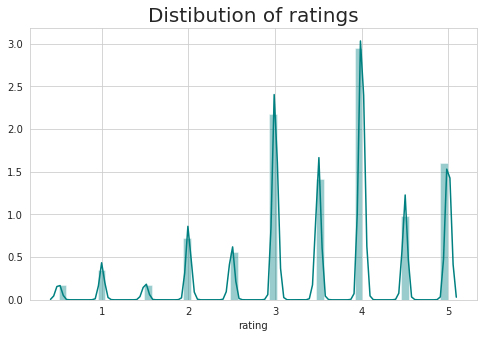

In [ ]:
plt.figure(figsize = (8, 5))
g = sns.distplot(train_data['rating'], color = 'teal')
g.set_title('Distibution of ratings', fontsize = 20)
plt.show()

Now. Are there users who watch a lot more movies than others. Look at the output below. Looks like user with ID 72315 has watched and rated nearly 13000 movies of the approx 48000 available in the data. Thats significant, especially considering he/she is seconded by a user wiyh 3680 in their list. Out of curiosity lets just take a look at what our top user rates his/her movies.

In [ ]:
num_of_movies_watched = train_data.groupby('userId')['movieId'].count().sort_values(ascending = False)
num_of_movies_watched

userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
          ...  
55362         1
121071        1
127098        1
53640         1
105714        1
Name: movieId, Length: 162541, dtype: int64

From the figure below the top user's most common rating is 3. EWe'll just assume that any rating above 3 means he likes the movie and any below 3 he dislikes the movie. I think we can conclude that he likes more movies than he dislikes. Note that although we have extreme users like our top user, there are users who've watched as few movies as 1 in the dataset. Let's just be aware of this as we move on.

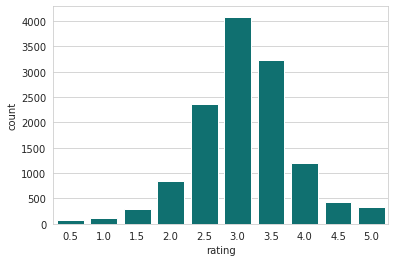

In [ ]:
top_user = num_of_movies_watched.index.tolist()[0]
top_user
top_user_ratings = train_data[train_data['userId'] == top_user]['rating']
top_user_ratings
sns.countplot(top_user_ratings, color = 'teal')

Similar to what we did above, are there movies that tend to be watched and rated by most users. Seeing the output below. There are movies that have been watched by more than 30000 users in the dataset. Thats approximately 21% of all the users. These are very popular movies. Out of curiosity we'll take the top 10 most popular movies and visualise their average rating.

In [ ]:
num_of_users_per_movie = train_data.groupby('movieId')['userId'].count().sort_values(ascending = False)
num_of_users_per_movie

movieId
318       32831
356       32383
296       31697
593       29444
2571      29014
          ...  
152731        1
152733        1
152737        1
152743        1
209171        1
Name: userId, Length: 48213, dtype: int64

Looking at the figure below, the most common rating for this group of movies is 3. Also, the movies tend to be liked more than they are disliked, which makes sense given how popular they are.

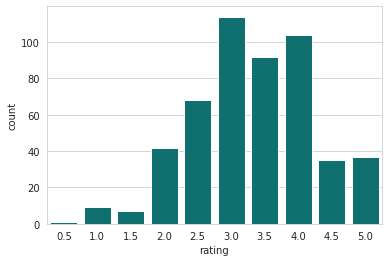

In [ ]:
ten_most_popular_movies = num_of_users_per_movie[:10].index.tolist()
data = train_data[train_data['userId'].isin(ten_most_popular_movies)]
sns.countplot(data['rating'], color = 'teal')

Looks like we're approaching a conclusion that most of the ratings tend to be concentrated around either a certain group of users i.e the top users or a certain group of movies i.e most popular movies. Let's ask a more direct question. What is the proportion of ratings accounted for by top users? Similarly, what proportion of the ratings is accounted for by the most popular movies?

###### task: analysing dimensionality
See the figure below. On the x axis we have the number of users (left) and the number of movies (right) and on the y axis we have the proportion of ratings corresponding to the number of either users and/or movies on the x axis. For example, see that if we take the most common 60000 users we already have 80% of the ratings in the database. This is even more acute for the movies i.e 10000 movies hold nearly 100% of the rating in the database. Most users do watch a lot of movies and most movies are not watched by a lot of users.

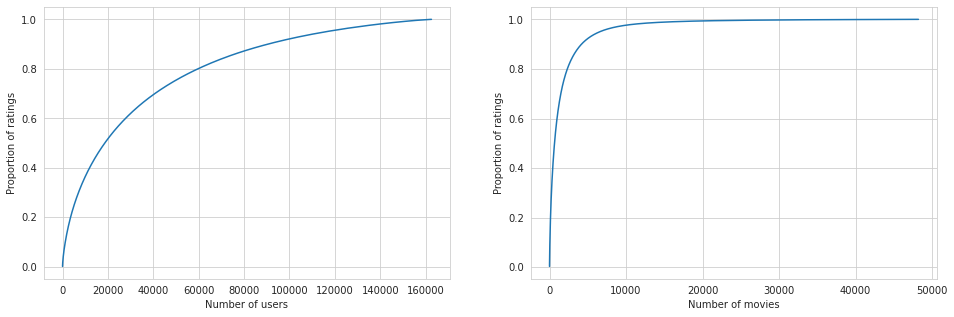

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
g = num_of_movies_watched.cumsum().div(len(train_data)).reset_index()['movieId'].plot(ax = axes[0])
# g.set_title()
g.set_xlabel('Number of users')
g.set_ylabel('Proportion of ratings')

g = num_of_users_per_movie.cumsum().div(len(train_data)).reset_index()['userId'].plot(ax = axes[1])
# g.set_title()
g.set_xlabel('Number of movies')
g.set_ylabel('Proportion of ratings')
plt.show()

Further, we find that only about 6% (9677 users) of the users have watched more than 200 movies in the database and that only 0.38% have watched less than 5 movies suggesting that users generally watch between 5 and 200 movies(84% of users).

In [ ]:
more_than_200 = num_of_movies_watched > 200
userids_w_more_than_200 = num_of_movies_watched[more_than_200].index
print(f"Only {len(userids_w_more_than_200)} users have watched more than 200 movies in the dataset.")

Only 9677 users have watched more than 200 movies in the dataset.


In [ ]:
less_than_5 = num_of_movies_watched < 5
userids_w_less_than_5 = num_of_movies_watched[less_than_5].index
print(f"{len(userids_w_less_than_5)} users have watched less than 5 movies in the dataset.")

618 users have watched less than 5 movies in the dataset.


Below we show a visual of the number of movies watched by users excluding the users with more than 200 movies in their watched list. See that the most viewership count is between 5 and 25 where we have more than 60000 users. This number ofcoarse declines as we move along the x axis. The average number of movies watched is 42.

The average number of movies watched for this group is 41.91420567598701 



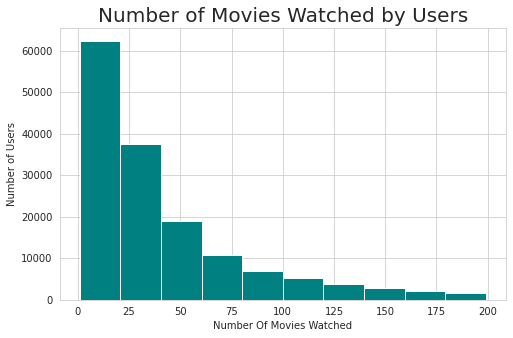

In [ ]:
fig = plt.figure(figsize = (8, 5))

less_than_200 = num_of_movies_watched < 200
data = num_of_movies_watched[less_than_200]
print(f"The average number of movies watched for this group is {data.mean()} \n")

g = data.plot(kind = 'hist', color = 'teal')
g.set_xlabel('Number Of Movies Watched')
g.set_ylabel('Number of Users')
g.set_title('Number of Movies Watched by Users', fontsize = 20)
plt.show()

Similar to above, we can visualise the count of users per movie ID in the dataset. The figure below indicates that most movies (more than 40000 of the 48000) are watched by only a few hundred users (about 300).

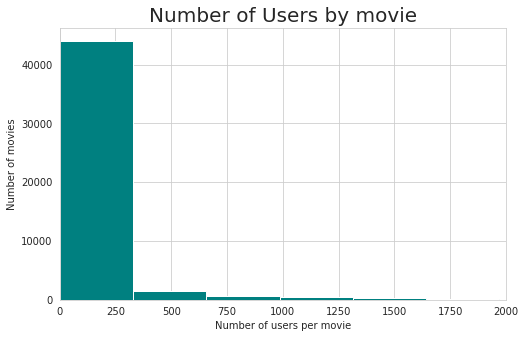

In [ ]:
fig = plt.figure(figsize = (8, 5))
g = num_of_users_per_movie.plot(kind = 'hist', bins = 100, color = 'teal')
g.set_xlim(0, 2000)
g.set_ylabel('Number of movies')
g.set_xlabel('Number of users per movie')
g.set_title('Number of Users by movie', fontsize = 20)
plt.show()

In [ ]:
n = 300
movieids_w_less_than_n = num_of_users_per_movie[num_of_users_per_movie < n].index
print(f"{len(movieids_w_less_than_n)} are watched on average by {n} users in the dataset.")

43816 are watched on average by 300 users in the dataset.


In [ ]:
n = 2000
movieids_w_more_than_n = num_of_users_per_movie[num_of_users_per_movie > n].index
print(f" Only {len(movieids_w_more_than_n)} movies have been watched by more than {n} users in the dataset.")

 Only 1223 movies have been watched by more than 2000 users in the dataset.


###### conclude
By now we know a lot about the ratings data. We've leant that most of the ratings data points available in the training data are concentrated in a select group of users. The same is true of the movies. This information will have important implications for the recemmendation systems we'll attempt to build later, especially ones where a movie recommendation to a user is based on how similary that user is to other users who have watched the movie. The users who've watched many movies in the database will tend to feature prominently in making those recommendations. Do we want that? Also, we saw that there are users who've only watched a few movie in the database. The extreme being one. Now, how would we determine how similar this user is to other users if they have only so few data points. These are insughts we gained from this section and we need to remain aware of them as we move on. Now we'll go on to analysing movie specific information such as the cast, directors, key words etc.

### Movie specific information

In [ ]:
from textblob import TextBlob

In [ ]:
tags['tag']

In [ ]:
polarity = list()
subjectivity = list()
for tag in tags['tag']:
    blob = TextBlob(str(tag))
    polarity.append(blob.sentiment[0])
    subjectivity.append(blob.sentiment[1])

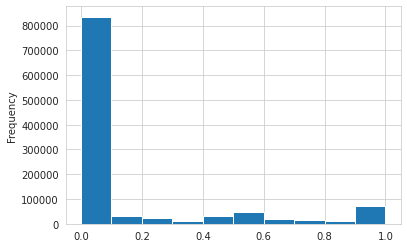

In [ ]:
pd.Series(subjectivity).plot(kind = 'hist')

## EDA Part 2
As we have seen the dataset provided is really big. A central theme in recommendation systems is that although there may be many users in a platform, if grouped and partitioned, their data will tend to reveal groups/segments with similar viewing habits. A simplistic example of this is data that reveals users who tend to like say action movies and totally dislikes romantic movies. The reason I say "simplistic" here is because user preferencences are generally much more complex than that. Certain movies, and commonly so, will have combinations of characteristics i.e action, thriller and fantasy. And very oftenly these attributes combine non-linearly and are therefore difficult to model. In this section we'll make an attempt to identify such groups. The section outlines as follows:
- We'll utilise principal components analysis to reduce the dimensionality of the movie attributes such as genre, cast, directors etc and visualise groups of movies
- We'll utilise kmeans clustering to group users based on their preferences for different genres.
- Finally, we'll group users by making an attempt at estimating the originaly distribution of user genre ratings using a gaussian mixture process.

Details of how we complete these tasks are provided in the respective sections. Lets begin.

### Principal Components Analysis

### Clustering with K-Means
As mentioned in the outline we'll first use kmeans to identify groups of similary users. Kmeans is a popular clustering algorithm that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean. The cluster means are also known as cluster centroids. Kmeans creates exclusive clusters (i.e non-overlapping clusters) and minimises the within cluster sum of squared distances. Utilising Kmeans can be computationally expensive, however, heuristic algorithms can be utilised the implement an iterative refinement approach, where the cluster centroids are initialised randomly, sum of squared distances computed, then cluster centroid are updated and so on. The resulting clusters are thus susceptible to how the centroids are initialised.

#### The User Bias
That being said, let's talk about how Kmeans can be applied to our data. In the previuos section we saw how PCA captures most of the variation in the movie-movie features matrix. Here our concern in in the users and only the genre movie features. The aim is to identify groups of users who like to associate themselves with particular genres. This immediately raises an issue very common in ratings based recommendation systems i.e the user bias. User bias is based on the premise that users have differening perspectives on how the rating scale works. Let's take an example of an optimistic user. When this user likes a movie they rate it say a 4.5. Now, say there's a perssimist who also watches that same movie. Let's assume they like the movie just as much as the optimist, but because they're a persimist they give it a rating of 3.5. At surface level, these two users barely feel the same about this movie. Any technique that attemts to understand the preferences based on raw ratings will thus be biased. Here's a solution, suppose the optimist's average rating for all the movies they've watched is 4. This value will ofcoarse be high because this user tends to be optimistic about movies. The average is low, 3, for persimmist. See that if we measure user preferences based on how far a given rating deviates from the user's average rating we'll be able to see that the 2 users feel exactly the same abot the movie, the optimistic user will have a rating of 4.5-4=0.5 and the perssimist will have a rating of 3.5-3=0.5. This is known as a normalised/unbiased rating in recommeder systems literature. This is how we intend to analyse our ratings data. The cell below chieves that purpose.

In [ ]:
# compute normalised ratings
data = train_data.groupby('userId')['rating'].mean().reset_index().rename(columns = {'rating':'avg_rating'})
train_data = pd.merge(train_data, data, on = 'userId')
train_data['norm_rating'] = train_data['rating'].sub(train_data['avg_rating'])
train_data.head()

,userId,movieId,rating,avg_rating,norm_rating
0,5163,57669,4.0,4.136364,-0.136364
1,5163,68157,5.0,4.136364,0.863636
2,5163,1247,4.5,4.136364,0.363636
3,5163,441,4.0,4.136364,-0.136364
4,5163,2671,1.0,4.136364,-3.136364


So far, all we know is that we are going to use clustering technques to identify groups of users. On what basis are wo to do so? One option is to use the actual movie ratings and attempt to identify groups based on the movies they like. Although this approach sounds plausible it has 2 complecations. First, we'll need a user-item(movie) matrix where the rows are the users, the columns are the movies and the cells are normalised ratings. Note that this matrix will be saprse as most users have not watched and therefore rated most movies, we saw this in EDA Part 1. We cannot cluster a matrix with more missing values than non-missing values. Secondly, even if we were able to cluster that matrix, it would be a approximately a 140000*48000 matrix, too big to fit in normal computer memory. As such we'll look into grouped movies as a second option. The movie groups are determined by genre. So instead of having the original matrix, we'll have one that has all the users on the rows and just the movie genres on the columns.Now how many genres do we have for movies. The table displayed below shows a few rows of the movies table that contains the genres.

In [ ]:
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


To count the number of unique genres we have we'll loop through the genre column, collecting all the genres and counting the number of those that are unique. Seee code cell below.

In [ ]:
list_of_genres = list()
for string in movies_data['genres']:
    tokens = string.split('|')
    for token in tokens:
        list_of_genres.append(token)
pd.Series(list_of_genres).nunique()

20

We have 20 unique entries in the genre columns. Of coarse certain records are tagged with multiple genres. In the cell below we use a counter function from the collections package to determine the most frequently occuring genres. The 5 most common are Drama, Comedy, Thriller, Romance and Action. Drama occurs way too frequently, more than 50% of the movies in the dataset have atleast the Drama tag. For the purposes of our clustering algorithm we'll not include Drama. Other tags occur too infrequently. We'll limit our analysis to the top 5 genre tags excluding Drama.

In [ ]:
from collections import Counter
Counter(list_of_genres).most_common()

[('Drama', 25606),
 ('Comedy', 16870),
 ('Thriller', 8654),
 ('Romance', 7719),
 ('Action', 7348),
 ('Horror', 5989),
 ('Documentary', 5605),
 ('Crime', 5319),
 ('(no genres listed)', 5062),
 ('Adventure', 4145),
 ('Sci-Fi', 3595),
 ('Children', 2935),
 ('Animation', 2929),
 ('Mystery', 2925),
 ('Fantasy', 2731),
 ('War', 1874),
 ('Western', 1399),
 ('Musical', 1054),
 ('Film-Noir', 353),
 ('IMAX', 195)]

As discussed above, we'll only be taking comedy, romance, thriller and action. Now we want to compute each user's average normalised rating for movies they've watched in each of the chosen genres. Below, we define a function that takes as input a dataset with userId, movieId and normalised ratings, a dataset with movieId and genre tags and lastly a list of genres of interest, in our case the for genres identified above. The output of this function is a dataframe object with users as rows and their average normalised rating for a given genre. This is computed as the sum of the normalised rating divided by the number of movie watched with that genre tag.

In [ ]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre)]
        avg_genre_votes_per_user = (
            ratings[ratings['movieId']
                    .isin(genre_movies['movieId'])]
                    .loc[:, ['userId', 'norm_rating']]
                    .groupby(['userId'])['norm_rating']
                    .mean()
                    .round(2))
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = [f"avg_{genre}_rating" for genre in genres]
    return genre_ratings

In [ ]:
# get genre ratigs
genre_ratings = get_genre_ratings(
    train_data, movies_data, 
    ['Comedy','Thriller', 'Romance', 'Action'])
genre_ratings.head()

,avg_Comedy_rating,avg_Thriller_rating,avg_Romance_rating,avg_Action_rating
1,-0.12,1.09,-0.08,1.09
2,-0.33,0.36,-0.39,0.03
3,-0.25,-0.04,-0.17,-0.07
4,0.19,-0.11,-0.06,-0.27
5,-0.14,-0.07,-0.05,-0.74


The output looks as displayed above. The row indexes are the userId as per training data. Looking at a summary description of the data below we see that users sometimes rate movies -4 points below what they would rate their average movie, look at the minimum. Similarly, ratings can be 3 points above what an average movie would be rated, see the maximum. However, the mean/average tends to regress towards 0 indicating that although such low/high normalised rating can occur, they occur with little frequency.

In [ ]:
genre_ratings.describe()

,avg_Comedy_rating,avg_Thriller_rating,avg_Romance_rating,avg_Action_rating
count,160040.000000,157872.000000,152414.000000,158164.000000
mean,-0.106847,-0.024439,-0.009314,-0.103786
std,0.386979,0.435191,0.505956,0.446319
min,-4.040000,-4.040000,-4.000000,-3.920000
25%,-0.260000,-0.190000,-0.220000,-0.280000
50%,-0.080000,0.000000,0.010000,-0.070000
75%,0.080000,0.180000,0.240000,0.110000
max,2.910000,3.920000,3.860000,3.370000


Note also that we have some missing data points here, upto 6%. These are a result of users whe have not watched a single movie in a given genre. Its just a few point however, we can just drop them. We do this in an upcoming cell.

In [ ]:
genre_ratings.isnull().sum() / len(genre_ratings)

avg_Comedy_rating      0.015314
avg_Thriller_rating    0.028653
avg_Romance_rating     0.062235
avg_Action_rating      0.026857
dtype: float64

Now what we want to do may sound not so intuitive. We want to intentionally bias our genre ratings dataset. Why? Remember, we our intention is to identify groups of users based on the movies they like, we are not really interested in the movies they do not like. Including data points on movies users do not like will just add noisy patterns and our clustering algorithm may fail to identify important relationships in the data. Now, remember we said a normalised rating can be interpreted as how much more (>0) or less (<0) a user likes a movie. The best way to bias the data towards users who like movies is to filter the normalised rating to get only thos that are greater than 0. Or we can user 0.2 to reduce the probability of false positive. The cell below accomplishes that task.

In [ ]:
action_mask = genre_ratings['avg_Action_rating'] > 0.2
comedy_mask = genre_ratings['avg_Comedy_rating'] > 0.2
thriller_mask = genre_ratings['avg_Thriller_rating'] > 0.2
romance_mask = genre_ratings['avg_Romance_rating'] > 0.2
X = genre_ratings[action_mask | comedy_mask | thriller_mask | romance_mask].dropna() ### drop NaNs
X.head()

,avg_Comedy_rating,avg_Thriller_rating,avg_Romance_rating,avg_Action_rating
1,-0.12,1.09,-0.08,1.09
2,-0.33,0.36,-0.39,0.03
7,0.00,-1.00,0.50,-1.00
8,0.25,0.06,-0.15,0.18
9,-0.03,0.43,0.18,-0.63


Now we will use sklearn to learn the grouping. sklearn has a cluster module that comes with a KMMeans class. Yet another thing to note is that Kmeans allows the user to choose the nomber of cluster (k). We'll do an implementation where we try out different values of k. We'll then utilise the elbow method to select an appropriate k based on the lowest value of sum of squared distances. See below.

In [ ]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

The sum of squared distances will generally decline continuosly as k increase. The idea however, is not to get the best sum of squared distances as this will always be where k is equaly to the number of sample. The idea is to identify a k where the sum of squared distances in acceptable. Also, intuition and domain knowledge can come in handy in this regard. In our case we'll use the figure below as well as intuition. When k is 5, the ssd is not minimised but acceptable and besides we dont want to many clusters as this may cloud the trully differentiating features among the users. So we will choose 5.

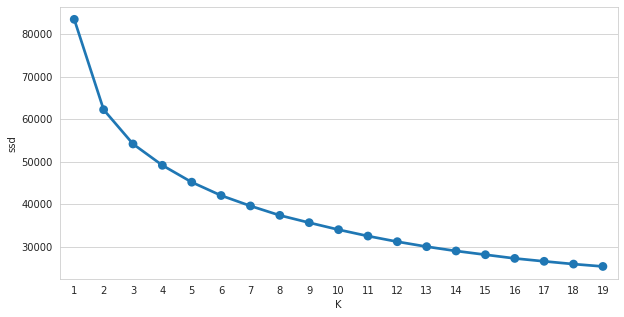

In [ ]:
rez = pd.DataFrame({'ssd':Sum_of_squared_distances, 'K':range(1, 20)})
fig = plt.figure(figsize = (10, 5))
sns.pointplot(data = rez, x = 'K', y = 'ssd')

Go ahead and fit the model with 5 clusters and add a column of the cluster in our data.

In [ ]:
kmeans = KMeans(5)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
X = pd.concat([X, pd.DataFrame(kmeans.predict(X) + 1, index = X.index)], axis = 1).rename(columns = {0:'km_clusters'})
X['km_clusters'] = X['km_clusters'].map(lambda x: f"clus_{x}")
X.head()

,avg_Comedy_rating,avg_Thriller_rating,avg_Romance_rating,avg_Action_rating,km_clusters
1,-0.12,1.09,-0.08,1.09,clus_5
2,-0.33,0.36,-0.39,0.03,clus_5
7,0.00,-1.00,0.50,-1.00,clus_4
8,0.25,0.06,-0.15,0.18,clus_5
9,-0.03,0.43,0.18,-0.63,clus_3


We can also check the number of users in each cluster. See below figure. Note that this may flag one of the major limitations of Kmeans clustering. The technique tends to perform poorly if the true number of observations falling in each cluster is different. Another limitation is the methods' failure to separate non-linearly separable data. That being said, let's proceed.

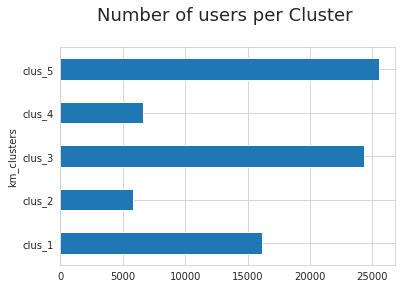

In [ ]:
g = X.groupby('km_clusters').count()['avg_Romance_rating'].plot(kind = 'barh')
g.set_title('Number of users per Cluster \n', fontsize = 18)
plt.show()

Next we plot a heat map of the clusters aginst the movie groups. See heatmap below. Here we see that indeed there are distinct groups of users. See for example users in cluster 1 and those in cluster 5. These group both tend to like ramance movie. The only diffrentiating feature between these group in their differeing levels of dislike for action movies, cluster 5 hates them more, but they also like comedies, while those in cluster 1 don't really like them. We also see that cluster 2 and 3 tend to like thriller and action and dislike everything else. Cluster 4 is a group of users who dont really like many movies, maybe we can say that they are comfortable with comedies.

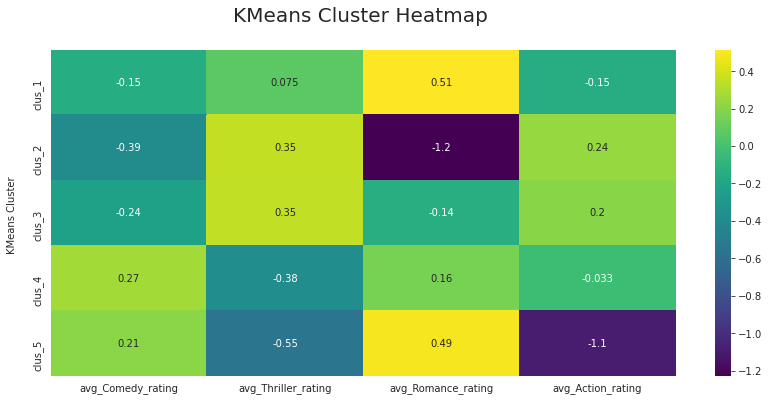

In [ ]:
fig = plt.figure(figsize = (14, 6))
g = sns.heatmap(X.groupby('km_clusters').mean(), cmap = 'viridis', annot = True)
g.set_title('KMeans Cluster Heatmap \n ', fontsize = 20)
g.set_ylabel('KMeans Cluster \n')
plt.show()

What are the implecation of these findings for a typical recommender system. Well, it looks like action and thriller tend to go together almost all the time. Further, Comedy and Romance sometimes go together, not all the time. Users generally don't mix action/thriller based movies with Comedy/Romance based movies.

We can further visualise our findings at a smaller dimension that the actual data. We'll implement PCA on the normalised ratings, get the first 2 components, plot a scatter of them in a 2 dimentional space and color the obseration by the clusters from our Kmeans model. See following code cells. The 2 principal components explain more than 70% of the variation in the data.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X.iloc[:, :-1])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print(f"The 2 principal components explain {round(sum(pca.explained_variance_) * 100, 2)}% of the variation in the data")

The 2 principal components explain 71.2% of the variation in the data)


Next we want to plot the graph. See below.

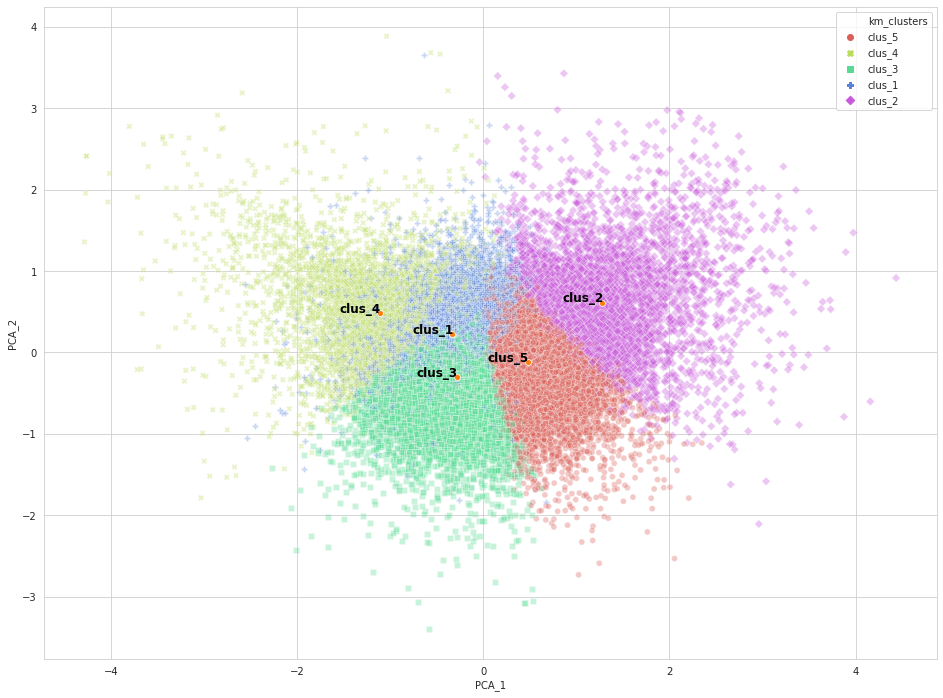

In [ ]:
data = pd.DataFrame(pca.transform(X.iloc[:, :-1]), columns = ['PCA_1', 'PCA_2'])
data['km_clusters'] = X['km_clusters'].to_list()

fig = plt.figure(figsize = (16, 12))
g = sns.scatterplot(data = data, x = 'PCA_1', y = 'PCA_2', hue = 'km_clusters', style = 'km_clusters', palette = 'hls', alpha = 1/3)

mean_data = data.groupby('km_clusters').mean().reset_index()
g = sns.scatterplot(data = mean_data, x = 'PCA_1', y = 'PCA_2', legend = False)

for line in mean_data.index:
     g.text(mean_data.PCA_1[line]+0.01, mean_data.PCA_2[line]+0.01, 
     mean_data.km_clusters[line], horizontalalignment='right', 
     size='large', color='black', weight='semibold')

Looks like PCA is doing a satisfactory job reducing the dimensionality of the data. We see a clear separation between the groups, the labelled points a re the cluster centriods. We see a reccuring trend here, most of the data is in cluster 5 and 3. However, although the cluster sizes are different Kmeans seems to be doing a satisfactory job as well.

###### conclude
This marks the end of EDA Part 2. This has been an interesting section. We attempted to group movies based on such content as genre, cast, director etc without any luck of finding informative patterns. We proceeded and tried to group users. This endevour turned out to be slightly more successful than that of grouping movies. We determined that users can be group into clusters with similar preferences based on the types of movie genres they like. These findings were made more precise by utilising normalised ratings rather than raw ratings that tend to be haunted by a phenomenon know as user bias. We further implemented PCA on the normalised movie genre ratings and understood the patterns at a lower dimension than the original data. The findings from PCA visualisation served to cement those found by Kmeans clustering.

# Recommendation Systems
Wikipedia describes recommendation systems as a subclass of information filtering system that seek to predict the "rating" or "preference" a user would give to an item. In our use case the item is a movie or list of movie we beileve the user would like to watch. The intention with this section of the notebook is to build such recommendation systems and generate for each user a playlist of movies that we think the user will like. These types of model range from the most simplistic approaches like popularity engines that simply recommend the most popular items (they can be surprisingly perfomant) to slightly more complex techniques like content based recommenders to even more complex techniques like collaboration filters. Our intention is to explore most of these options in our study. As you may have noticed the theme, recommendation systems data tend to have specific issues. We already spoke about the user bias, now we'll talk about another common issue known as the cold start problem.

##### The Cold Start Problem
Often, recommendations are made based on how similar a user or item is to other users or items. Models utilising this approach are known as collaborative filter, as the name implies i.e other users or collaborate to make recommendations to other users. Although these techniques often perform well, in real production systems they tend to suffer from a problem known as cold start. This speaks to either a new user or item/movie that does not yet have enough data/information or usage history that can be utilised to identify similarities. Note that this problem can still occur for users/items that have little data such that the computed similarities may not be very precise. As such this issue is going to be a reccuring theme in this section. The section outlines as follows:
- we first implement a simplistic popularity recommender.
- we then build a content based recommender based on movie tags data taking into account their relevance.
- Next, we'll look into the class of collaborative filtering methods (the not so advanced techniques known as memory based filters as well as the advance ones known as model based filters)

The details of how the model work and their implementation will be explained as and when they become relevant.

### Popularity Based Recommendation Engine

### Content Based Recommendation Engine
Content-based filtering methods are based on a description of the item and a profile of the user's preferences.These methods are best suited to situations where there is known data on an item, but not on the user. So this section is based on the assumption that we have no known data about the users.The idea is to use keywords that describe the items and build a user profile to indicate the type of items this user likes. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past, or is examining in the present. The advantage with this technique is that it can be used as a temporary profile for new users while we compile more comprehensive data points for the user to be able to use advanced techniques.

The details of the implementation are as follows. We have a table that contains genome tags and their relevance. See the tables displayed below.

In [ ]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


The table above gives us tag ids and well as movie ids. The one below shows us the actual tag ids and their mapping to tag ids. Our interest is in the actual tags. We also see that the tags can ordered by relevance. Ideally we want to utilise the most relevant tags.

In [ ]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


Let's revisit the table genome_scores again. In the table we have 13816 unique movies and each movie has 1128 tags associated with it. Thats a lot. We'll only get the 50 most relevant tags for now.

In [ ]:
genome_scores['movieId'].nunique()

13816

In [ ]:
(genome_scores['movieId'].value_counts() == 1128).any()

True

Below, we write a function that get the 50 most relevant tags for each movie. The tags are then joined to create a single document of tags. The resulting output is a dataframe with 2 colimns, a movie id column and the tags column that has the documents for each movie id.

In [ ]:
def getMostRelevantTags(n_most_relevant_tags = 50):
    text_data = pd.DataFrame()
    for i, movie_id in enumerate(genome_scores['movieId'].unique()):
        tags_text = {}
        mask = genome_scores['movieId'] == movie_id
        tag_ids = genome_scores[mask].sort_values('relevance', ascending = False).iloc[:n_most_relevant_tags,]['tagId'].to_list()
        tags_list = genome_tags[genome_tags['tagId'].isin(tag_ids)]['tag'].to_list()
        tags_text[movie_id] = ' '.join(tags_list)
        data = pd.DataFrame(tags_text, index = [0]).transpose().rename(columns = {0:'tags'})
        text_data = pd.concat([text_data, data])
        # print(i, movie_id)
    return text_data

In [ ]:
text_data = getMostRelevantTags(n_most_relevant_tags = 50)
text_data = text_data.reset_index().rename(columns = {'index':'movieId'})
text_data.head()

,movieId,tags
0,1,action adventure affectionate animated animati...
1,2,action adaptation adventure animals bad cgi ba...
2,3,betrayal catastrophe chase comedy crappy seque...
3,4,adaptation adapted from:book adultery bad acti...
4,5,bittersweet catastrophe chase comedy crappy se...


Further, we are interested in the actual movie title. These are stored in the movies_data table as displayed below. We want to associate each of the movie ids in text_data with its movie title, we utilise a merge operation for this, see below.

In [ ]:
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
text_data = pd.merge(text_data, movies_data[['movieId', 'title']], how = 'left') 
text_data.head()

,movieId,tags,title
0,1,action adventure affectionate animated animati...,Toy Story (1995)
1,2,action adaptation adventure animals bad cgi ba...,Jumanji (1995)
2,3,betrayal catastrophe chase comedy crappy seque...,Grumpier Old Men (1995)
3,4,adaptation adapted from:book adultery bad acti...,Waiting to Exhale (1995)
4,5,bittersweet catastrophe chase comedy crappy se...,Father of the Bride Part II (1995)


Now we have a nice dataframe containing our textual information. Further, if there are any movie title that are duplicated, we want to drop them, see below.

In [ ]:
text_data.drop_duplicates('title', inplace = True)

Now, say we want to visualise the most common tags associated with a certain movie, say Jumanji, how would we go about this? We'll plot a wordcloud of that movie's tags. Below, we write a function that takes as input a movie title and returns a word cloud of that movie's tags. We then provide the movie title for Jumanji, 1995 to see the tags in a wordcloud. See that if Jumanji is popular, she's known for being an action, fantasy, effect and cgi movie. The idea with the recommender system we build here is that if a user like Jumanji then it is highly likely that they will like other movies that have a wordcloud similar to this one. We'll try to verify this hypothesis later.

In [ ]:
from wordcloud import WordCloud

def plotCloud(movie_title):
    text = text_data[text_data['title'] == movie_title]['tags'].iloc[0]
    word_cloud = WordCloud().generate(text)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(f"{movie_title} tags \n", fontsize = 20)
    plt.axis("off")
    plt.show()

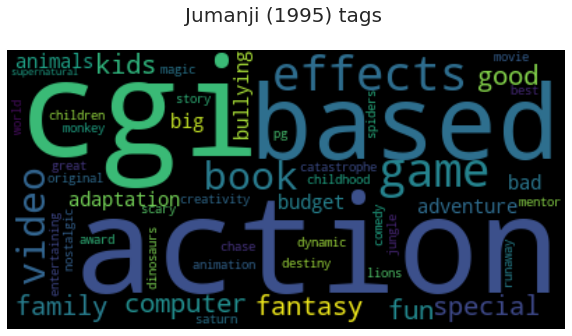

In [ ]:
movie_title = 'Jumanji (1995)'
plotCloud(movie_title = movie_title)

Now, we want to create a vactorised matrix of our tags. In this matrix, the rows are the movies and the columns are the tags. If a movie is associated with a certain tag we'll have a binary indicator in the cell. We utilise sklearn's CountVectorizer to complete that task. See below cell.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
text_matrix = vec.fit_transform(text_data['tags'])
text_matrix

<13813x1161 sparse matrix of type '<class 'numpy.int64'>'
	with 836743 stored elements in Compressed Sparse Row format>

Next, we want to compute similarities between movies in the matrix. We'll use cosine similarity. Cosine similarity is a measure of similarity between two vectors in a n-dimentional space. If two vectors are exactly alike or are in the same spot on the n-dimensional space their similarity should be 1. The lower the value of cosine similarity the more dissimilar two vector are. This technique will allow us to determine distances between movie vectors in a dimension thats much higher than a 2 dimensional space. Our matrix has 1161 columns but the concept is still the same. sklearn has a class that computes thse similaries, see cell below.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist_matrix = cosine_similarity(text_matrix)

In [ ]:
print(dist_matrix.shape)
dist_matrix = pd.DataFrame(dist_matrix, index = text_data['title'], columns = text_data['title'])
dist_matrix.head(3)

(13813, 13813)


title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),"American President, The (1995)",Dracula: Dead and Loving It (1995),Balto (1995),Nixon (1995),Cutthroat Island (1995),Casino (1995),Sense and Sensibility (1995),Four Rooms (1995),Ace Ventura: When Nature Calls (1995),Money Train (1995),Get Shorty (1995),Copycat (1995),Assassins (1995),Powder (1995),Leaving Las Vegas (1995),Othello (1995),Now and Then (1995),Persuasion (1995),"City of Lost Children, The (Cité des enfants perdus, La) (1995)",Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Dangerous Minds (1995),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Wings of Courage (1995),Babe (1995),Carrington (1995),Dead Man Walking (1995),Across the Sea of Time (1995),It Takes Two (1995),Clueless (1995),"Cry, the Beloved Country (1995)",...,Wine Country (2019),The Lighthouse (2019),Long Shot (2019),Men in Black: International (2019),Toy Story 4 (2019),Brightburn (2019),Midsommar (2019),Murder Mystery (2019),Spider-Man: Far from Home (2019),Yesterday (2019),Stuber (2019),I Am Mother (2019),The Art of Self-Defense (2019),Crawl (2019),Pain and Glory (2019),Always Be My Maybe (2019),Rim of the World (2019),Once Upon a Time in Hollywood (2019),Parasite (2019),Child's Play (2019),Late Night (2019),Deadwood: The Movie (2019),Anna (2019),Scary Stories to Tell in the Dark (2019),Good Boys (2019),The Lion King (2019),Shaft (2019),Annabelle Comes Home (2019),Fast & Furious Presents: Hobbs & Shaw (2019),The Great Hack (2019),Ad Astra (2019),It: Chapter Two (2019),In the Tall Grass,Joker (2019),Ready or Not (2019),Zombieland: Double Tap (2019),Downton Abbey (2019),El Camino: A Breaking Bad Movie (2019),Dave Chappelle: Sticks & Stones (2019),Between Two Ferns: The Movie (2019)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.377671,0.400000,0.317396,0.380591,0.313928,0.376718,0.401751,0.105240,0.293259,0.384066,0.141296,0.506555,0.264996,0.296946,0.320815,0.269565,0.211597,0.189312,0.282592,0.340615,0.211171,0.150747,0.243673,0.229706,0.394752,0.400099,0.181820,0.177069,0.156386,0.289427,0.207794,0.336712,0.643088,0.152617,0.229373,0.427770,0.473702,0.336712,0.216357,...,0.227946,0.256998,0.374380,0.207223,0.580565,0.276360,0.305596,0.306420,0.340853,0.466252,0.137824,0.253045,0.254362,0.304695,0.244187,0.393625,0.285081,0.378560,0.357776,0.157372,0.317303,0.417391,0.235418,0.241331,0.249296,0.395773,0.269390,0.142022,0.216254,0.203235,0.344049,0.352987,0.119242,0.402334,0.277591,0.389463,0.316942,0.358245,0.320827,0.229366
Jumanji (1995),0.377671,1.000000,0.262728,0.345084,0.233992,0.183073,0.355689,0.453540,0.397462,0.350726,0.252996,0.124515,0.371078,0.217919,0.404063,0.167396,0.246307,0.118055,0.127675,0.302393,0.197908,0.089722,0.223665,0.300861,0.086753,0.223630,0.268633,0.261593,0.135837,0.068906,0.377757,0.057223,0.317916,0.421660,0.230556,0.209101,0.284559,0.323021,0.249177,0.306419,...,0.215221,0.074662,0.222188,0.303266,0.337328,0.309255,0.133964,0.335979,0.402283,0.342398,0.199533,0.230070,0.163311,0.505630,0.144098,0.265466,0.249229,0.095895,0.100428,0.138682,0.396232,0.361251,0.202948,0.294319,0.174355,0.454476,0.381529,0.321826,0.252797,0.141393,0.137812,0.343382,0.235406,0.198571,0.196572,0.342068,0.157500,0.183620,0.128511,0.196875
Grumpier Old Men (1995),0.400000,0.262728,1.000000,0.500139,0.716926,0.378560,0.615612,0.471620,0.229615,0.391012,0.598429,0.348530,0.358082,0.247899,0.393017,0.396798,0.243478,0.413576,0.504832,0.499245,0.445419,0.274522,0.226120,0.393625,0.174577,0.438613,0.551247,0.138529,0.077468,0.156386,0.425628,0.173162,0.382213,0.464452,0.193315,0.150279,0.447214,0.640376,0.409514,0.333550,...,0.383363,0.217460,0.599008,0.362641,0.535907,0.409423,0.349253,0.622725,0.350322,0.652753,0.312400,0.328021,0.437502,0.461659,0.315408,0.543578,0.327315,0

The sahpe of our similarities matrix is 13813 by 13813 as expected. At thsi point, most of the implementation of our content based recommender has been done. Now we just want a function that quiries the similarities matrix to identify movies that are most similar to a given movie. Below, we write a function that does just that, we get the n most similar movies for each of the movies in the genome_tags table. The default value on n is 10, this can be changed.

In [ ]:
def getRecommendations(neighbors = 10):
    similarity_data = pd.DataFrame()
    for i, movie_title in enumerate(dist_matrix.index):
        sim_data = dist_matrix.loc[movie_title].reset_index()
        sim_data['movie'] = movie_title
        sim_data = sim_data.rename(columns = {movie_title:'similarity', 'title':'recommendations', 'movie':'title'}).sort_values(by = 'similarity', ascending = False)[1:].iloc[:10]
        sim_data['rank'] = range(1, len(sim_data) + 1)
        similarity_data = pd.concat([similarity_data, sim_data])
    return similarity_data

In [ ]:
similarity_data = getRecommendations(neighbors = 10)
similarity_data

,recommendations,similarity,title,rank
2807,Toy Story 2 (1999),0.880217,Toy Story (1995),1
4407,"Monsters, Inc. (2001)",0.880191,Toy Story (1995),2
8809,Ratatouille (2007),0.831177,Toy Story (1995),3
2094,"Bug's Life, A (1998)",0.798600,Toy Story (1995),4
10284,Toy Story 3 (2010),0.797207,Toy Story (1995),5
...,...,...,...,...
13473,Game Night (2018),0.566635,Between Two Ferns: The Movie (2019),6
11896,Stretch (2014),0.563369,Between Two Ferns: The Movie (2019),7
12322,Comedy Central Roast of James Franco (2013),0.559133,Between Two Ferns: The Movie (2019),8
8878,"Darwin Awards, The (2006)",0.553399,Between Two Ferns: The Movie (2019),9


The output is similarities data table that displays as above. Now we can go ahead and quiry that table for any movie. Say we want to see the 10 movies that are most similar to Jumanji, 1995. This is how we do it, see cell below. See that Jumanje, 1995 is most similar to Jurassic Park, 1993. If you've watched these movies, or atleast their modern version, you should know these are similar action, fantasy movies. Looks like our content based recommender is already doing a really good job.

In [ ]:
movie_title = 'Jumanji (1995)'
sim_data = similarity_data[similarity_data['title'] == movie_title]
sim_data

,recommendations,similarity,title,rank
459,Jurassic Park (1993),0.687046,Jumanji (1995),1
9593,Dinotopia (2002),0.650651,Jumanji (1995),2
9419,Journey to the Center of the Earth (2008),0.648610,Jumanji (1995),3
3580,How the Grinch Stole Christmas (a.k.a. The Gri...,0.643653,Jumanji (1995),4
9243,"Spiderwick Chronicles, The (2008)",0.643182,Jumanji (1995),5
1381,"Lost World: Jurassic Park, The (1997)",0.639390,Jumanji (1995),6
10264,Prince of Persia: The Sands of Time (2010),0.630521,Jumanji (1995),7
8309,"Chronicles of Narnia: The Lion, the Witch and ...",0.610483,Jumanji (1995),8
2168,Mighty Joe Young (1998),0.601462,Jumanji (1995),9
5783,Lara Croft Tomb Raider: The Cradle of Life (2003),0.599592,Jumanji (1995),10


Further, we can go ahead and look at a wordcloud for Jurassic Park, 1993. It displays as below. This is like a nearly perfect copy of the one we saw earlier for Jumanji, 1995.

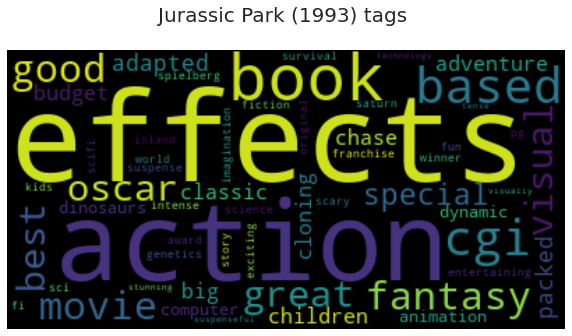

In [ ]:
movie_title = sim_data['recommendations'].iloc[0]
plotCloud(movie_title = movie_title)

Now we want to visualise our findings by utilising 2 principal components from PCA. The idea is to plot these components in a 2 dimensional scatter plot and map 5 movies that are most similar to Jumanji, 1995 and the should be located relatively close to each other on the space. The cell below uses sklearn's PCA class to achieve that task.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(text_matrix.toarray())

The first 2 components of from our PCA model explain just a little over 10% of the variation in out text matrix. Remember this matrix is sparse and high demensional, there's only so much that we can summarise with 2 components. We can only hope that these 2 components do a well in displaying how similar these movies are.

In [ ]:
pca.explained_variance_

array([6.12645063, 4.76354058])

In [ ]:
# get the components in a df along with movie titles
pca_rez = pd.DataFrame(principal_components)
pca_rez['title'] = text_data['title']
pca_rez.columns = ['PCA_1', 'PCA_2', 'title']
pca_rez.tail()

,PCA_1,PCA_2,title
13808,-0.528654,2.878692,In the Tall Grass
13809,4.214399,1.437450,Joker (2019)
13810,-0.168849,1.066955,Ready or Not (2019)
13811,0.500300,0.368941,Zombieland: Double Tap (2019)
13812,-1.834995,-0.028586,Downton Abbey (2019)


The next thing we want to go is get a list of the movies that we identify as most similar to Jumanji as well as their indices in the dr pca_rez. We want to use the indices to create a binary column that we'll use to add only the most similar movie titles in the scatter plot.

In [ ]:
movies = list()
for movie in ['Jumanji (1995)']:
    similar_movies = similarity_data[similarity_data['title'] == movie]['recommendations'][:5].tolist()
    for similar_movie in similar_movies:
        movies.append(similar_movie)
movies

In [ ]:
indz = list()
for i, movie in enumerate(pca_rez['title']):
    if movie in movies + ['Jumanji (1995)']:   # the indices should also include Jumanji, 1995
        indz.append(i)
indz

[1, 459, 3580, 9243, 9419, 9593]

In [ ]:
# adding the binary indicator column, has value 1 for the movies of interest, zero otherwise
pca_rez['indicator'] = np.where(pca_rez['title'].isin(movies), 'Yes', 'No')
pca_rez.head()

,PCA_1,PCA_2,title,indicator
0,0.705908,3.160393,Toy Story (1995),No
1,-1.499692,2.161723,Jumanji (1995),No
2,-2.174972,4.040087,Grumpier Old Men (1995),No
3,-0.503630,3.336362,Waiting to Exhale (1995),No
4,-2.112422,3.296430,Father of the Bride Part II (1995),No


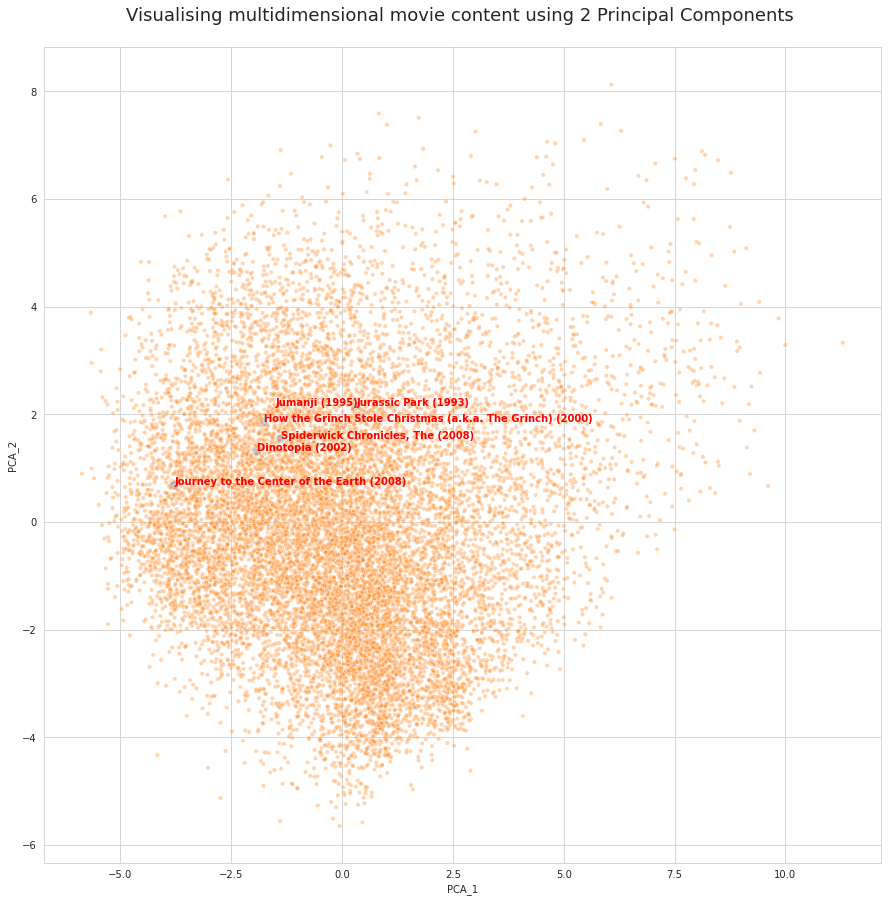

In [ ]:
# plot scatter and hue by the indicator
fig = plt.figure(figsize = (15, 15))
g = sns.scatterplot(data = pca_rez, x = 'PCA_1', y = 'PCA_2', alpha = 1/3, legend = False,
                    hue = 'indicator', hue_order = ['Yes', 'No'], size = 'indicator', size_order = ['Yes', 'No'])
g.set_title('Visualising multidimensional movie content using 2 Principal Components \n', fontsize = 18)

# add the text labels
for line in indz:
     g.text(pca_rez.PCA_1[line]+0.01, pca_rez.PCA_2[line]+0.01, 
     pca_rez.title[line], horizontalalignment='left', 
     size='medium', color='red', weight='semibold')

Look at that. These mappings are really good especially considering that the 2 PCA components explain only about 10% of all the variation in the data. Journey to the Center of the earth seems to be the furthest movie from Jumanji, 1995, but we know its the third closest. Again, this is likely because we are only visualising a smaller dimension of the PCA components. If we could visualise much higher dimensions, it is highly likely that these movies would lie much, much closer in that space.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(text_matrix.toarray())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13813 samples in 2.234s...
[t-SNE] Computed neighbors for 13813 samples in 428.286s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13813
[t-SNE] Computed conditional probabilities for sample 2000 / 13813
[t-SNE] Computed conditional probabilities for sample 3000 / 13813
[t-SNE] Computed conditional probabilities for sample 4000 / 13813
[t-SNE] Computed conditional probabilities for sample 5000 / 13813
[t-SNE] Computed conditional probabilities for sample 6000 / 13813
[t-SNE] Computed conditional probabilities for sample 7000 / 13813
[t-SNE] Computed conditional probabilities for sample 8000 / 13813
[t-SNE] Computed conditional probabilities for sample 9000 / 13813
[t-SNE] Computed conditional probabilities for sample 10000 / 13813
[t-SNE] Computed conditional probabilities for sample 11000 / 13813
[t-SNE] Computed conditional probabilities for sample 12000 / 13813
[t-SNE] Computed conditional probabilities for 

In [ ]:
tsne_rez = pd.DataFrame(tsne_results)
tsne_rez['title'] = text_data['title']
tsne_rez.columns = ['TSNE_1', 'TSNE_2', 'title']
tsne_rez.tail()

,TSNE_1,TSNE_2,title
13808,-1.852449,3.036692,In the Tall Grass
13809,5.358327,2.475039,Joker (2019)
13810,0.045463,-0.521400,Ready or Not (2019)
13811,0.584157,0.703434,Zombieland: Double Tap (2019)
13812,-1.597441,0.521146,Downton Abbey (2019)


In [ ]:
tsne_rez['indicator'] = np.where(tsne_rez['title'].isin(movies), 'Yes', 'No')
tsne_rez.head()

,TSNE_1,TSNE_2,title,indicator
0,-5.679520,6.020809,Toy Story (1995),No
1,-7.247961,0.260053,Jumanji (1995),No
2,-2.372248,3.522848,Grumpier Old Men (1995),No
3,-0.447933,5.525204,Waiting to Exhale (1995),No
4,-2.643892,5.897009,Father of the Bride Part II (1995),No


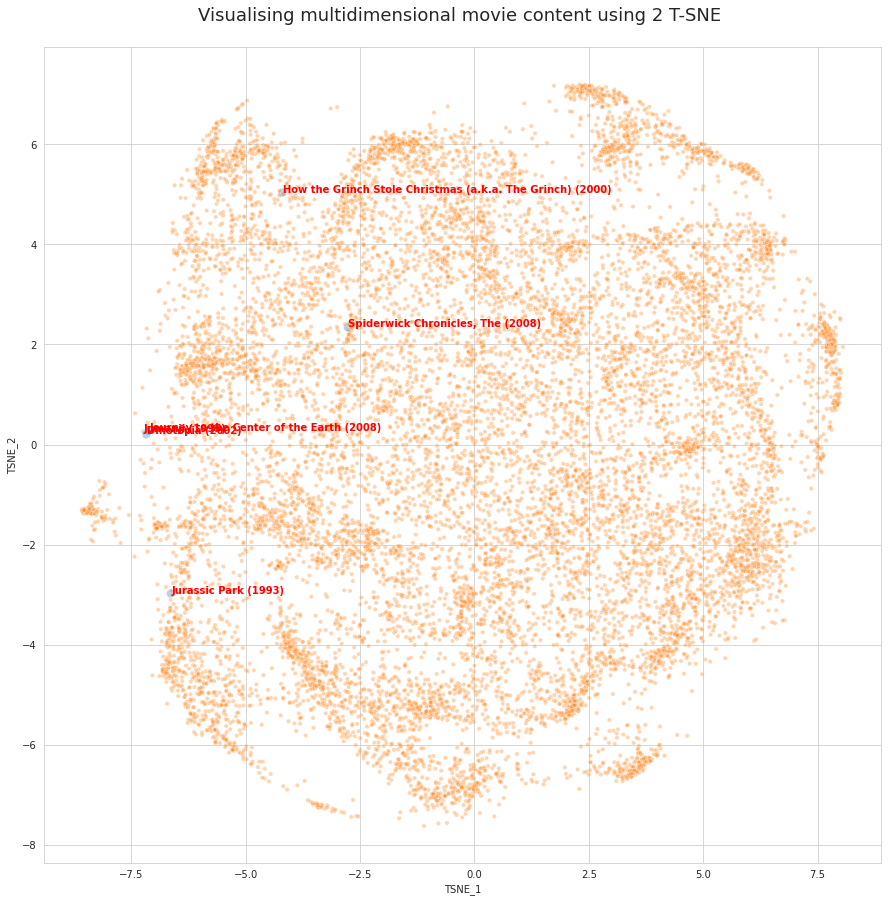

In [ ]:
fig = plt.figure(figsize = (15, 15))
g = sns.scatterplot(data = tsne_rez, x = 'TSNE_1', y = 'TSNE_2', alpha = 1/3, legend = False,
                    hue = 'indicator', hue_order = ['Yes', 'No'], size = 'indicator', size_order = ['Yes', 'No'])
g.set_title('Visualising multidimensional movie content using 2 T-SNE \n', fontsize = 18)

for line in indz:
     g.text(tsne_rez.TSNE_1[line]+0.01, tsne_rez.TSNE_2[line]+0.01, 
     tsne_rez.title[line], horizontalalignment='left', 
     size='medium', color='red', weight='semibold')

#### Word Embeddings (Word2Vec)

In [ ]:
# Download NLTK Dependencies
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# NLP libraries
import nltk
from nltk.corpus import stopwords

In [ ]:
# Function to remove punctuation
def removePunctuation(tag):
    """
    Return the removal of punctuation and other uncommon characters in the tag.
    
    Parameters
    ----------
        tag (str): string containing punctuation to be removed.
        
    Returns
    -------
        clean_tag (str): string without punctuation.
        
    Examples
    --------
    >>> removePunctuation("Hey! Check out this story: urlweb. He doesn't seem impressed. :)")
            
        "Hey Check out this story urlweb He doesn't seem impressed"
    """    
    # first remove line spaces
    clean_tag = tag.replace('\n', ' ')
    
    # substitute digits within text with an empty strring
    clean_tag = re.sub('\w*\d\w*', ' ', clean_tag)
    
    # remove punctuation
    # some of the character removed here were determined by visually inspecting the text
    clean_tag = re.sub(r'[:;.,_()/\{}"?\!&¬¦ãÃâÂ¢\d]', '', clean_tag) 
    
    # return cleaner tweet
    return clean_tag

In [ ]:
# Function to remove stop words
def removeStopWords(tag):
    """
    This method removes stop words and punctuation relics.
    
    Parameters
    ----------
        tokenized_tag (list): list of tokens to be cleaned.
        
    Returns
    -------
        clean_tag (list): list of tokens without stopwords.
        
    Examples
    --------
    >>> removeStopWords(['read',
                        'latest',
                        'on',
                        'climate',
                        'change',
                        'insurance',
                        'amp',
                        'lending',
                        'featuring',
                        'apra',
                        'speech',
                        'and',
                        'work',
                        'urlweb'])
                        
        ['read',
        'latest',
        'on',
        'climate',
        'change',
        'insurance',
        'amp',
        'lending',
        'featuring',
        'apra',
        'speech',
        'and',
        'work',
        'urlweb']
    """
    # initialising an empty list as container for the cleaned tweet
    clean_tag = list()
    # iterating through all words in a list
    for token in tag:
        # checking if current word is not a stopword # also checking if the current word is a hash_tag # also checking if the current word has more than one character
        if token not in stopwords.words('english') and len(token) > 1:
            clean_tag.append(token)            
    # return the cleaner tweet
    return clean_tag

In [ ]:
tags_corpus = text_data['tags'].map(lambda tag: removeStopWords(removePunctuation(tag).split())).tolist()

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
tagged_corpus = [TaggedDocument(words = D, tags = [str(i)]) for i, D in enumerate(tags_corpus)]

In [ ]:
# instantiate Doc2Vec model

max_epochs = 50
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size = vec_size,
                alpha = alpha, 
                min_alpha = 0.00025,
                min_count = 1,
                dm = 0) # paragraph vector distributed bag-of-words (PV-DBOW)
  
model.build_vocab(tagged_corpus)

In [ ]:
print('Epoch', end = ': ')
for epoch in range(max_epochs):
  print(epoch, end = ' ')
  model.train(tagged_corpus,
              total_examples=model.corpus_count,
              epochs=model.epochs)
  # decrease the learning rate
  model.alpha -= 0.0002
  # fix the learning rate, no decay
  model.min_alpha = model.alpha

Epoch: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [ ]:
tags_vectors = model.docvecs.vectors_docs
tags_vectors.shape

(13813, 20)

In [ ]:
model.wv.most_similar(positive = ['action', 'adventure', 'comedy', 'fantasy'], negative = ['action'], topn = 5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('crisis', 0.6227580308914185),
 ('new', 0.6174702048301697),
 ('las', 0.5970859527587891),
 ('corporate', 0.5922664403915405),
 ('feature', 0.5737387537956238)]

In [ ]:
pd.DataFrame(tags_vectors, 
             columns = [f"vector_{i + 1}" for i in range(tags_vectors.shape[1])]).head()

,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,vector_10,vector_11,vector_12,vector_13,vector_14,vector_15,vector_16,vector_17,vector_18,vector_19,vector_20
0,1.291890,-1.539893,-1.156680,-0.465776,-0.607159,-0.312232,-0.326387,0.333244,-1.017409,0.638979,-2.396566,0.661439,-0.198627,1.094297,-0.982876,-0.932556,-0.636511,-1.680676,0.416619,-0.096964
1,-0.730672,-0.806983,-0.078757,0.625563,-0.614147,0.329009,-0.014277,0.744920,-0.769224,1.884400,-1.798500,0.435749,-0.973734,0.347880,-0.364353,-1.111171,-0.342330,-1.268988,0.572591,0.520455
2,0.672670,-0.752259,-2.175913,0.849413,-0.824027,0.098909,-0.170803,-0.706765,-0.041432,0.021805,-0.910173,-0.639956,0.074233,-2.002166,0.639710,-0.548704,0.146077,-0.092819,0.310379,0.119208
3,-0.408786,-0.706768,-1.674320,-0.446082,-0.287017,-0.025572,0.098409,-0.971459,1.170160,0.361279,-0.158224,-0.275247,-0.623602,-0.531459,0.414236,-1.468928,0.379464,0.458205,1.213742,-0.812081
4,0.881523,-0.554798,-2.151955,0.656253,-1.239652,0.939049,0.273155,-0.909127,-0.652684,-0.383624,-0.919121,-0.075412,0.563673,-1.017214,0.220561,-2.149870,0.530612,0.161611,0.739459,-0.506765


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300, learning_rate = 10)
tsne_results = tsne.fit_transform(tags_vectors)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 13813 samples in 0.039s...
[t-SNE] Computed neighbors for 13813 samples in 9.209s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13813
[t-SNE] Computed conditional probabilities for sample 2000 / 13813
[t-SNE] Computed conditional probabilities for sample 3000 / 13813
[t-SNE] Computed conditional probabilities for sample 4000 / 13813
[t-SNE] Computed conditional probabilities for sample 5000 / 13813
[t-SNE] Computed conditional probabilities for sample 6000 / 13813
[t-SNE] Computed conditional probabilities for sample 7000 / 13813
[t-SNE] Computed conditional probabilities for sample 8000 / 13813
[t-SNE] Computed conditional probabilities for sample 9000 / 13813
[t-SNE] Computed conditional probabilities for sample 10000 / 13813
[t-SNE] Computed conditional probabilities for sample 11000 / 13813
[t-SNE] Computed conditional probabilities for sample 12000 / 13813
[t-SNE] Computed conditional probabilities for sam

In [ ]:
tsne_rez = pd.DataFrame(tsne_results)
tsne_rez['title'] = text_data['title']
tsne_rez.columns = ['TSNE_1', 'TSNE_2', 'title']
tsne_rez.tail()

,TSNE_1,TSNE_2,title
13808,-0.412867,0.115544,In the Tall Grass
13809,0.200098,-1.353951,Joker (2019)
13810,2.230870,-0.070763,Ready or Not (2019)
13811,1.947667,-1.528522,Zombieland: Double Tap (2019)
13812,0.689855,0.924766,Downton Abbey (2019)


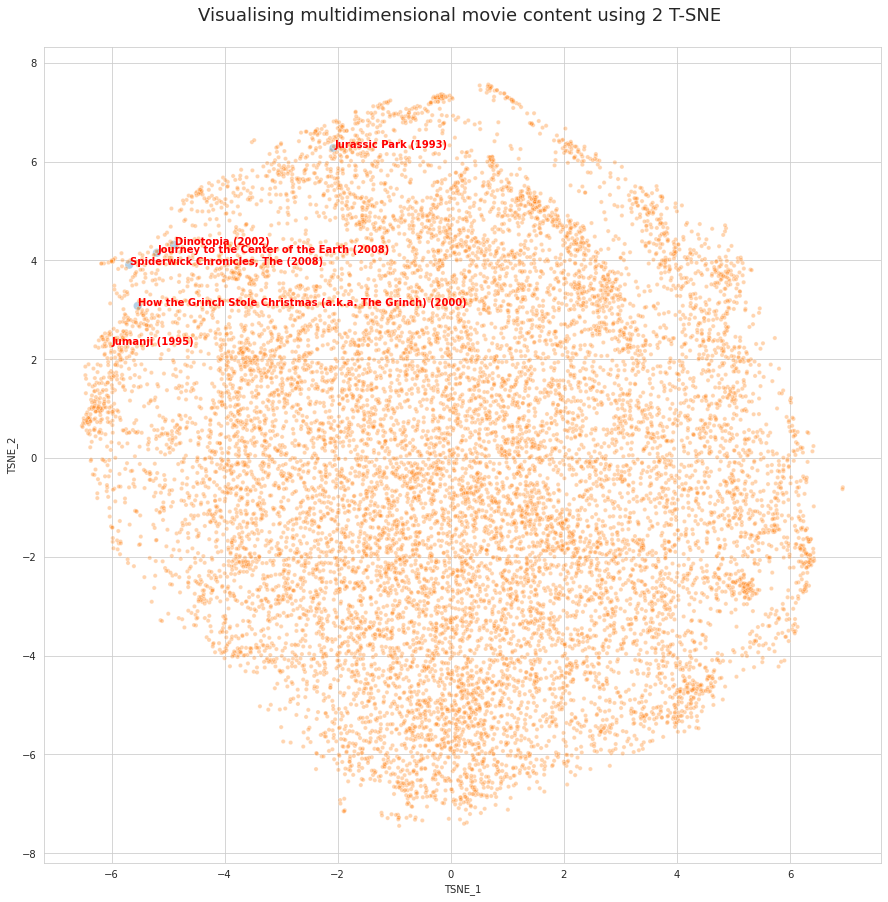

In [ ]:
tsne_rez['indicator'] = np.where(tsne_rez['title'].isin(movies), 'Yes', 'No')

fig = plt.figure(figsize = (15, 15))
g = sns.scatterplot(data = tsne_rez, x = 'TSNE_1', y = 'TSNE_2', alpha = 1/3, legend = False,
                    hue = 'indicator', hue_order = ['Yes', 'No'], size = 'indicator', size_order = ['Yes', 'No'])
g.set_title('Visualising multidimensional movie content using 2 T-SNE \n', fontsize = 18)

for line in indz:
     g.text(tsne_rez.TSNE_1[line]+0.01, tsne_rez.TSNE_2[line]+0.01, 
     tsne_rez.title[line], horizontalalignment='left', 
     size='medium', color='red', weight='semibold')

In [ ]:
import umap

In [ ]:
sq_umap = umap.UMAP(n_neighbors = 5,
                    min_dist = 0.001,
                    metric = 'cosine').fit_transform(tags_vectors)

In [ ]:
umap_rez = pd.DataFrame(sq_umap)
umap_rez['title'] = text_data['title']
umap_rez.columns = ['UMAP_1', 'UMAP_2', 'title']
umap_rez.tail()

,UMAP_1,UMAP_2,title
13808,5.594001,0.968970,In the Tall Grass
13809,1.421387,1.973647,Joker (2019)
13810,5.263000,7.201360,Ready or Not (2019)
13811,1.249037,4.027101,Zombieland: Double Tap (2019)
13812,5.668641,3.180087,Downton Abbey (2019)


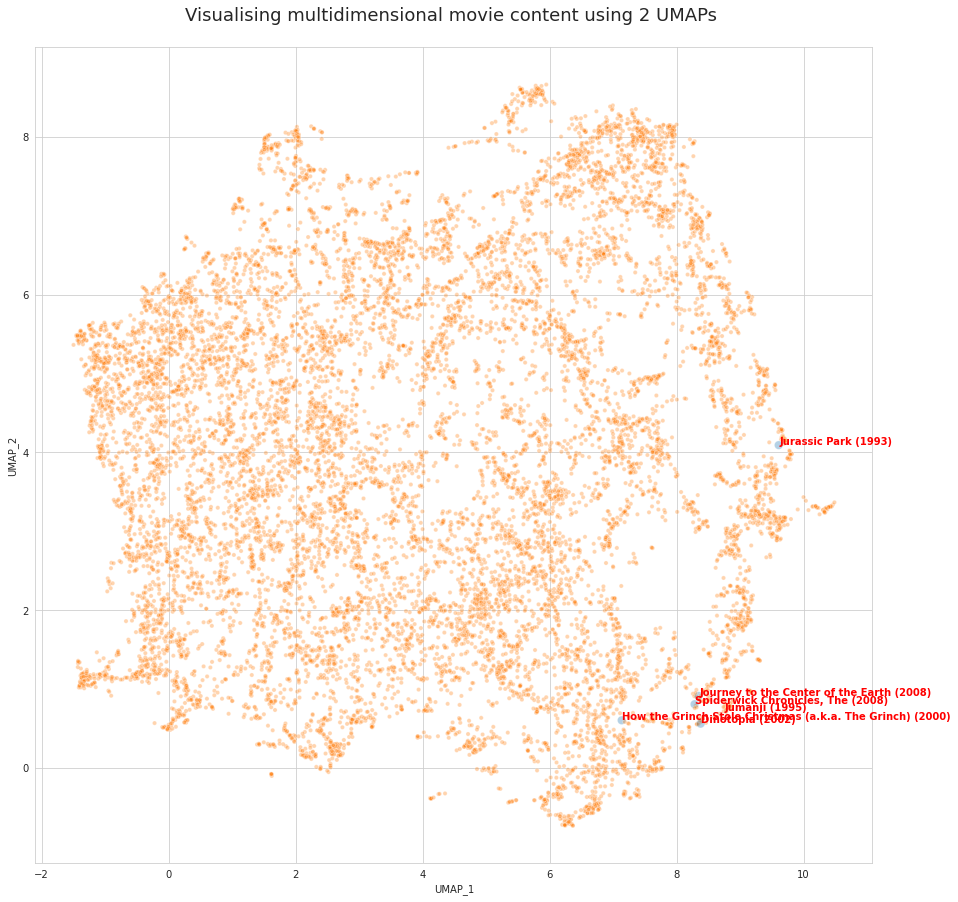

In [ ]:
umap_rez['indicator'] = np.where(umap_rez['title'].isin(movies), 'Yes', 'No')

fig = plt.figure(figsize = (15, 15))
g = sns.scatterplot(data = umap_rez, x = 'UMAP_1', y = 'UMAP_2', alpha = 1/3, legend = False,
                    hue = 'indicator', hue_order = ['Yes', 'No'], size = 'indicator', size_order = ['Yes', 'No'])
g.set_title('Visualising multidimensional movie content using 2 UMAPs \n', fontsize = 18)

for line in indz:
     g.text(umap_rez.UMAP_1[line]+0.01, umap_rez.UMAP_2[line]+0.01, 
     umap_rez.title[line], horizontalalignment='left', 
     size='medium', color='red', weight='semibold')

### Collaboration Filtering Engines
Collaborative filters are a class of recommendation systems that are are based on the assumption that people who agreed in the past will tend to agree in the future, and that they will like similar kinds of items as they liked in the past. The system generates recommendations using only information about rating profiles for different users or items. By locating peer users/items with a rating history similar to the current user or item, they generate recommendations using this neighborhood. Collaborative filtering methods are classified as memory-based and model-based. A well-known example of memory-based approaches is the user-based algorithm, which we will examine while that of model-based approaches is the Matrix factorisation, which we'll also examine. The details of their implementation will be discussed as and when we come across them.

#### Memory Based Filters
As mentioned in the outline above we'll be implementing a user-user memory based filtering algorithm. We'll first go through a simplistic implementation of technique and later implement a more advanced version known as K nearest neighbor with means. The two methods describe as follows:
##### Custom Recommender
Our custom built model borrows several techniques from more popular approaches out there. These techniques assume that users generally have similar preferences and these preferences can be mined from ratings data. As such, users who have watched certain items can collaborate and provide expected ratings for users who have not watched those items. Here's a simple example, say of 10 users with similar preferences, 6 have watched and rated a certain movie. Their 6 ratings can be combined to provide an estimate of the rating each of the other 4 users would give to those movies and if those ratings are high we go ahead and recommend those movies. The number of users who can contribute to that estimate (aka neighbors) can be determined by the analyst and their ratings combined in a linear fashion. i.e it could be the average or more popularly the weighted average so that users who are most similar can have more say in the estimate. The degree of similarity can be measure by cosine, pearson correlation or any other measure of distance.

Our model takes a similar approach, similarities between users will be computed based on pearson correlation. However, once we've determined similar users, instead of combining their rating using an analytic approach like computing a mean or a weighted mean, we'll use those nearest neighbor's rating as features in a linear regression model to learn the appropriate weights of combining the neighbors ratings. The number of neighbors will represent the number of predictor features and will still be a tuning paramer. We can go on explaining this but an illustration will go a long way. Let's go ahead and do the implementation. Below we outline the step required to do the implementation:
- We want to compute pearson correlations between users. Note that this is done on normalised ratings for reasons we discussed earlier.
- Next, for each user we want to determine the most similar users based on correlation and store these results.
- Next, we want to get the features for training our model. These are the ratings by n nearest neighbors who have watched the movie.
- Next, we want to get the target variable. Note that for training purposes this has to be movies that the user has actually watched.
- Next, we'll train a linear regressor to learn the mappings between n neighbor's ratings and the user's actual rating.
- Once the linear regressor is trained it can then be used to make predictions for movies that the user has not seen.

Let's get into the code. Ooh! there's one more implementation detail we skipped. Our approach requires that we create a user-item matrix. This has memory implications. As such we sample the data by taking only the 6000 active users as well as 20000 most actively view movies. It's still big, but workable. The code cells below filter the data to get the required sample.

In [15]:
n = 6000
m = 20000
users = train_data['userId'].value_counts()[:n].index
items = train_data['movieId'].value_counts()[:m].index
users_mask = train_data['userId'].isin(users)
items_mask = train_data['movieId'].isin(items)
sample_data = train_data[users_mask & items_mask]
sample_data = sample_data.reset_index().drop('index', axis = 1)
sample_data

,userId,movieId,rating
0,106362,32296,2.0
1,144018,1997,5.0
2,40858,5025,3.5
3,80119,92259,3.5
4,6063,33493,3.0
...,...,...,...
2691407,111647,381,5.0
2691408,145304,2502,4.0
2691409,130280,899,2.5
2691410,134451,1298,4.0


As can be seen the sample data is about 2.6 million rows, approximately 26% of the whole dataset. Following the steps of our implementation, we'll first create a user-item matrix of normalised ratings, See function definition below.

In [16]:
def getNormalisedMatrix(data):
    matrix = pd.pivot_table(data, values = 'rating', index = 'movieId', columns = 'userId')

    def computeNormalisedRating(ratings):
        return ratings - np.mean(ratings)

    normalised_matrix = matrix.apply(computeNormalisedRating, axis = 1) 
    return normalised_matrix

We then implement taht function to get the normalised matrix. It doesn't take too long to compute but dumping pickles in this section became a major theme because later steps take a bit of time to run. So you can load the pickles, more convinient. Looking at the displayed output, the matrix is rather sparse as expected. Many users have rated only a few movies.

In [ ]:
# # import pickle
# sample_matrix = getNormalisedMatrix(data = sample_data)

In [17]:
sample_matrix = pd.read_pickle('/content/drive/My Drive/Projects/recommendation_engine/sample_matrix(6000*20000).pickle')
sample_matrix.head()

userId,12,72,187,321,426,450,519,541,548,606,626,648,653,695,757,801,803,846,847,859,860,871,901,927,939,983,997,1038,1203,1228,1281,1305,1401,1405,1409,1477,1484,1503,1612,1652,...,161184,161205,161223,161251,161342,161382,161383,161421,161437,161484,161486,161544,161560,161561,161586,161675,161714,161826,161919,161928,161939,161946,162047,162067,162093,162245,162271,162286,162294,162297,162334,162349,162358,162368,162387,162445,162484,162495,162508,162516
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,-0.342981,-1.342981,NaN,0.657019,NaN,0.657019,0.157019,0.657019,NaN,NaN,0.157019,NaN,NaN,1.157019,NaN,0.157019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.842981,NaN,NaN,NaN,0.657019,NaN,NaN,NaN,-3.342981,NaN,0.157019,NaN,...,0.657019,NaN,NaN,NaN,-3.342981,1.157019,0.157019,NaN,0.157019,-0.342981,1.157019,NaN,0.157019,-0.342981,NaN,-0.342981,NaN,NaN,NaN,-0.842981,0.157019,NaN,NaN,NaN,NaN,NaN,NaN,0.157019,NaN,NaN,-0.342981,NaN,NaN,NaN,0.157019,-0.342981,NaN,-0.842981,0.657019,NaN
2,NaN,NaN,NaN,-0.049137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.049137,NaN,0.450863,NaN,0.950863,-0.549137,NaN,NaN,NaN,NaN,NaN,0.950863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.049137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.549137,-0.549137,-0.549137,-2.049137,NaN,0.950863,NaN,NaN,NaN,NaN,NaN,0.950863,-2.049137,1.950863,NaN,0.450863,0.450863,-2.049137,0.950863,NaN,NaN,NaN,-0.049137,-0.049137,NaN,-0.549137
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203704,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.203704,NaN,NaN,0.203704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.203704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203704,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.410405,NaN,NaN,NaN,1.410405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.589595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.323881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.176119,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.676119,NaN,NaN,NaN,NaN,NaN


Once we have a matrix of normalised ratings, we'll want to compute pearson correlations between our users. Luckily for us, pandas.corr() method can do this for us. However, first we realise that we'll want to be able to test the perfomance of this model later and the data we test it on cannot be used for computing correlations otherwise we'll have a data leakage and therefore inflated perfomance. So first we'll split the ratings matrix into 2 matrices, one for building the model and the other for testing the model. Looking at the shape of the split matrices we see that 12000 movies will be used during training and 8000 for testing.

In [18]:
from sklearn.model_selection import train_test_split
training_matrix, testing_matrix = train_sample_matrix = train_test_split(sample_matrix, test_size = 0.4, random_state = 42)
training_matrix.shape[0], testing_matrix.shape[0]

(12000, 8000)

Once the matrix is split we want to get compute the correlations. pandas,corr() compute correlation of the columns of a dataframe so we made sure that our users are the columns. An added bonus, pandas will also allow us to ignore correlations where users have very few movies that they've both watched. This will allow us to get more reliable correlation estimates. We want our users to have atleast 5 data points before correlation can be computed i.e have atleast 5 movies ratings. Lastly, this computation will take some time. It is advised that the reader loads a pickle of this matrix.

In [18]:
# # import pickle
# training_corr = training_matrix.corr(min_periods = 5)
# training_corr.to_pickle('/content/drive/My Drive/Projects/recommendation_engine/training_corr_matrix(6000*20000).pickle')

In [19]:
training_corr = pd.read_pickle('/content/drive/My Drive/Projects/recommendation_engine/training_corr_matrix(6000*20000).pickle')
training_corr.head()

userId,12,72,187,321,426,450,519,541,548,606,626,648,653,695,757,801,803,846,847,859,860,871,901,927,939,983,997,1038,1203,1228,1281,1305,1401,1405,1409,1477,1484,1503,1612,1652,...,161184,161205,161223,161251,161342,161382,161383,161421,161437,161484,161486,161544,161560,161561,161586,161675,161714,161826,161919,161928,161939,161946,162047,162067,162093,162245,162271,162286,162294,162297,162334,162349,162358,162368,162387,162445,162484,162495,162508,162516
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,1.000000,0.269639,-0.213869,0.054975,0.034742,0.034208,-0.150398,0.240334,-0.179348,-0.415815,0.136745,-0.215973,-0.175617,-0.024003,-0.216037,0.026512,0.155494,0.015113,0.207457,0.220747,-0.171593,-0.360707,0.082357,0.479863,-0.461650,-0.055972,-0.219959,-0.194872,-0.219669,-0.144078,-0.349388,-0.471955,-0.191684,0.056356,0.409545,-0.124742,0.451868,0.328845,-0.052116,-0.232761,...,0.081692,-0.034705,0.175608,0.557273,-0.175453,0.163055,-0.125420,0.184871,-0.137116,-0.082272,0.216353,0.188702,0.288099,-0.042710,0.535413,-0.179966,-0.044624,0.151928,-0.388203,-0.111058,0.419928,-0.409880,-0.123624,0.167164,0.193931,-0.182370,0.067817,-0.193668,0.063068,0.179100,0.302701,0.152238,-0.467348,0.013881,0.120159,0.093605,0.383294,-0.207408,0.145106,-0.063901
72,0.269639,1.000000,0.144007,0.139277,0.116231,0.422111,0.482700,0.103812,-0.159004,-0.557003,0.303051,-0.483650,0.043033,0.233361,-0.105447,-0.116688,-0.255658,-0.110816,-0.244116,-0.280940,0.164993,-0.259776,-0.169437,-0.112326,-0.017594,0.079095,-0.049526,-0.030096,0.035268,0.158617,-0.088982,-0.009765,-0.240546,0.064312,0.383533,-0.185720,-0.081137,0.217551,-0.238149,-0.098789,...,-0.277195,0.851275,-0.229500,0.082852,0.000957,-0.176341,0.095296,0.227728,-0.149536,-0.029345,0.301142,0.027647,-0.097982,-0.035280,0.076174,0.004718,0.057631,-0.148482,-0.190470,0.098060,-0.120793,-0.406806,0.057965,0.435730,-0.305089,-0.099222,0.084389,0.362271,-0.670094,0.407493,-0.458230,-0.217425,0.174809,0.264978,-0.159560,-0.010164,-0.347847,-0.155319,0.213807,-0.015571
187,-0.213869,0.144007,1.000000,-0.184429,0.195545,0.116705,-0.032050,-0.261527,-0.066921,0.013982,-0.215350,-0.040575,0.429135,0.416482,-0.183454,0.149568,-0.203061,-0.315742,-0.196732,0.005639,0.390126,-0.343978,-0.021629,-0.551717,0.116168,-0.234536,-0.111534,0.338594,-0.024417,0.146648,-0.561125,0.153362,-0.092461,-0.269276,0.099648,0.281002,0.364560,-0.317942,0.162401,0.030430,...,-0.096577,-0.319313,0.041031,0.216427,0.075219,0.433048,0.175869,0.099741,-0.114646,0.346110,-0.178109,-0.159055,0.035379,-0.171689,0.209153,-0.122156,0.157892,-0.046527,-0.062631,-0.029671,-0.026629,-0.430012,0.053502,0.079021,-0.259611,0.353294,0.070029,0.225800,0.189820,0.136098,0.444912,-0.053112,0.164819,0.073423,0.096246,-0.052165,0.012339,0.162184,0.244213,-0.052914
321,0.054975,0.139277,-0.184429,1.000000,0.529518,0.269730,0.017755,-0.064914,0.235185,-0.299779,-0.062294,0.291057,-0.030300,0.366347,0.065224,0.192109,0.043778,-0.006283,0.168391,0.122736,-0.154015,0.056819,0.207369,0.203140,-0.441622,-0.085255,0.028417,0.110740,-0.341029,0.256318,0.099951,-0.243555,-0.115435,-0.574906,0.364853,0.142145,-0.183958,-0.232030,-0.138781,-0.067346,...,0.311064,0.133339,0.159851,0.126858,-0.209211,0.078571,-0.155307,-0.258940,-0.154191,0.011304,0.262964,0.004530,-0.326463,0.520087,0.255626,-0.317852,-0.113580,0.048326,0.198938,-0.129793,-0.239913,-0.025786,-0.201394,-0.316733,-0.243976,-0.115646,0.149108,0.202833,0.292442,-0.253388,-0.035122,0.203161,-0.355380,0.027981,-0.031978,-0.056043,-0.288948,-0.278967,0.085166,-0.010606
426,0.034742,0.116231,0.195545,0.529518,1.000000,0.327923,0.143760,-0.056473,0.090748,-0.158304,-0.110055,0.030752,0.317890,0.481335,-0.225129,-0.227861,0.215892,0.210794,0.198667,0.124403,-0.142062,0.154019,-0.187687,-0.163772,-0.693471,-0.128227,0.355499,-0.213482,0.214899,-0.104645,0.160899,-0.401801,-0.046466,0.154711,0.038413,0.078349,0.163797,-0.332973,0.072158,-0.038509,..

Now that we our similarities matrix, we want to get the neigbors for each of the 6000 users we have in the sample data. So for each user we want to go to the correlation matrix, identify all users who have an estimated correlation coefficient and order these from highest to lowest. The resulting output is store in a BIG dictionary. The fuction below achieves that task in the most efficient way we could, perhaps there is a better, more optimised approach to doing this but it is all we have for now. Takes about 7 minutes to run and unfortunately we could not pickle the dictionary without running ou of memory. Please bear with us! This is the only part of the implementation yoy won't be able to get a ready made pickle file.

In [20]:
def getNeighbors(corr_matrix):
    similarity_scores = {}
    for user_id in corr_matrix.index:
        similarity_scores[user_id] = dict(corr_matrix.loc[user_id].dropna().sort_values(ascending = False)[1:])

    # order other users by similarity scores
    def sortDict(my_dict):
        return sorted(my_dict.items(), key = lambda scores: abs(scores[1]), reverse = True)
        
    similarity_scores = {user_id: sortDict(scores) for user_id, scores in similarity_scores.items()}
    return similarity_scores

In [ ]:
# file too big to pickle (RUNS FOR 7 MINUTES APPROX)
training_similarity_scores = getNeighbors(training_corr)

In [92]:
user_id = 12
training_similarity_scores[user_id][:5]

[(75309, -0.9386672235442203),
 (156523, -0.9001153785417211),
 (11750, 0.8838989447081512),
 (146609, 0.8681470358299633),
 (79678, -0.8530889551328477)]

The number of keys in the output dictionary is equal to the number of users we have in sample data, 6000 and each key represent a user id. The values in the dictionary is a list of tuple pairs where the first index is another user id and the second index is that user's similarity score with the user in the key. For example, in the display above we chose user id 12 and his/her top 5 nearest neighbors. Looks like users can be very similar based on those high correlations. Now we've reached a point where want to get the feature to train our models. Remember we want to predict ratings for a movie by a given user. That means we want a dataframe that havs movies as rows, the features being the ratings given by the n nearest neighbors and the output being the actual rating that was given by the user. Below we write a function, getFeatures(). The function takes as input a user id, a ratings matrix with normalised ratings where we get the features, a dictionary of similarity scores like the one we just discussed above and then number of neighbors which defaults to 5. Additionally, we have test_data and training_features as arguments. test_data becomes useful if you just want to get features to make predictions on a testing dataset for example like the one to submit on kaggle in which case you would set the following argument training to False, it is a boolean. Note that you'd heve to first get the training features either way to train the models. For our purposes for now, we'll set training to True to get the training features. The output is a tuple of X features for training and y the target for each user. Takes sometime to run, approximately 90 minutes as we get features for each of the 6000 users in a loop setting, it is advised that you load the pickles, see below.

In [26]:
def getFeatures(user_id, 
                ratings_matrix, 
                similarity_scores, 
                number_of_neighbors = 5, 
                test_data = None, 
                training_features = True):

    if training_features:
        # get all movies watched and rated by user
        user_data = ratings_matrix.loc[:, user_id].dropna() # drop movies not watched
        movies = user_data.index
    else:
        # get all movies unwatched by user
        # movies should also be on the testing dataset (kaggle)

        user_data = ratings_matrix.loc[user_id] # keep movies not watched
        movies_unrated = user_data[user_data.isnull()].index
        movies_in_test_data = training_corr.index
        movies = list()
        for movie in movies_unrated:
            if movie in movies_in_test_data:
                movies.append(movie)

    neighbor_recommendations = {}
    for movie_id in movies:
        list_of_recommendations = list()
        for tuple_pair in similarity_scores:
            other_user = tuple_pair[0]
            value = ratings_matrix.loc[movie_id, other_user]
            if not np.isnan(value):
                list_of_recommendations.append(value)
            if len(list_of_recommendations) == number_of_neighbors:
                break # from 5 most similar users
        
        if len(list_of_recommendations) == number_of_neighbors:
            neighbor_recommendations[movie_id] = list_of_recommendations
        else:
            features = len(list_of_recommendations)
            movie_mean = ratings_matrix.loc[movie_id].dropna().mean()
            for i in range(1, (number_of_neighbors + 1) - features):
                list_of_recommendations.append(movie_mean)
            neighbor_recommendations[movie_id] = list_of_recommendations

    X = pd.DataFrame(neighbor_recommendations).transpose()

    if training_features:
        y = list()
        for movie_id in movies:
            y.append(ratings_matrix.loc[movie_id, user_id])
    
    if training_features:
        return X, y
    else:
        return X

In [28]:
# ### DO NOT RUN ### load pickle files, see below
# number_of_neighbors = 5
# X_data_train = {}
# y_data_train = {}
# for i, user_id in enumerate(training_matrix.columns):
#     X, y = getFeatures(user_id, 
#                        training_matrix,
#                        training_similarity_scores[user_id], 
#                        number_of_neighbors, 
#                        training_features = True)
#     X_data_train[user_id] = X
#     y_data_train[user_id] = y

In [ ]:
# dump pickles
# pickle.dump(X_data_train, open("/content/drive/My Drive/Projects/recommendation_engine/X_data_train.p", "wb"))
# pickle.dump(y_data_train, open("/content/drive/My Drive/Projects/recommendation_engine/y_data_train.p", "wb")) 

In [84]:
import pickle
X_data_train = pickle.load(open("/content/drive/My Drive/Projects/recommendation_engine/X_data_train.p", "rb"))
y_data_train = pickle.load(open("/content/drive/My Drive/Projects/recommendation_engine/y_data_train.p", "rb")) 

Now the training data for the different users is stored in dictionaries X_data_train for the predictor vaviable and y_data_train for the target. See below for example predictors for user 12.

In [93]:
user_id = 12
X_data_train[user_id]

,0,1,2,3,4
222,-2.784790,0.715210,-0.284790,0.715210,0.715210
8360,0.623670,0.623670,0.123670,0.123670,0.123670
31435,0.315068,0.315068,0.315068,-0.684932,-0.184932
919,-0.865667,-0.365667,0.634333,0.134333,0.134333
40815,0.464598,-1.035402,-0.035402,-1.035402,0.964598
...,...,...,...,...,...
3168,-1.048969,0.451031,1.451031,1.451031,0.451031
1207,-0.570840,-1.070840,0.429160,-0.070840,0.429160
34437,0.997533,-0.002467,0.997533,0.497533,1.497533
5171,2.316220,0.316220,0.316220,-0.183780,0.316220


We can also get a glimpse at the target variable. See below. For example for movieId 1977 the nearest neighbor is saying the normalised rating is -2.78, while the second is saying its 0.71 etc, look at the first row in features table above. What this means is that those predictor values map to an expected rating of -0.28 for the user as indicated in the value in index 1 below. These are the relationships our linear model will attempt to learn. We can also do some mini data exploration here, look further below.

In [94]:
y_data_train[user_id][:5]

[-0.28478964401294515,
 0.12367021276595747,
 0.31506849315068486,
 0.13433292533659724,
 0.46459824980111364]

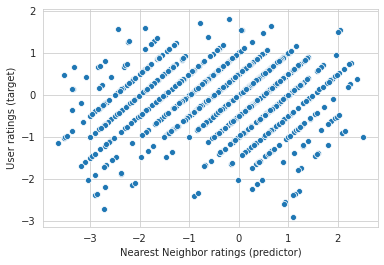

In [127]:
data = X_data_train[user_id].copy()
data['target'] = y_data_train[user_id]

# plot the most similar user ratings against user in question ratings
sns.scatterplot(data = data, x = 0, y = 'target')
# plt.title('Relationship between user ratings and nearest neighbor ratings \n', fontsize = 18)
plt.xlabel('Nearest Neighbor ratings (predictor)', fontsize = 10)
plt.ylabel('User ratings (target)')
plt.show()

The scatter plot doesnt look very promising, but either way lets continue. Moving forward, remember we said we want to test the predictions being made by our models. The testing ofcoarse can only be done on known ratings. We did split our data into training and testing earlier so all we have to do now is compute those data points for testing using the getFeatures() function again. This computation will also take some time thus it is recommended to load the pickles. See below.

In [96]:
# # ### DO NOT RUN ### load pickle files, see below
# X_data_test = {}
# y_data_test = {}
# for i, user_id in enumerate(testing_matrix.columns):
#     X, y = getFeatures(user_id, 
#                     testing_matrix, 
#                     training_similarity_scores[user_id], 
#                     number_of_neighbors, 
#                     training_features = True)
#     X_data_test[user_id] = X
#     y_data_test[user_id] = y
#     print(i + 1, user_id)

In [97]:
# pickle.dump(X_data_test, open("/content/drive/My Drive/Projects/recommendation_engine/X_data_test.p", "wb")) 
# pickle.dump(y_data_test, open("/content/drive/My Drive/Projects/recommendation_engine/y_data_test.p", "wb")) 

In [77]:
X_data_test = pickle.load(open("/content/drive/My Drive/Projects/recommendation_engine/X_data_test.p", "rb"))
y_data_test = pickle.load(open("/content/drive/My Drive/Projects/recommendation_engine/y_data_test.p", "rb")) 

Similarly, we'll get 2 dictionaries as before one for the predictictors and another for the target. Next we write a function that takes a model object, a regressor in our case and predictors X and the target y. Ofcoarse any regression model can be used here, we choose to be simplisic.

In [98]:
def fitModel(regressor, X, y):
    regressor = regressor
    regressor.fit(X, y)
    return regressor

Next we want to fit the models and test their predictions on the test. Note that we do this for each user in the dataset. Seems like this takes some time to happen but trust me, it's the fastest computation of all the steps we've done so fat, just run the cell below and wait for a minute. The loss function is the root mean squared error.

In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# initialise list object to store rmse per user
scores = {}
for i, user_id in enumerate(X_data_test.keys()):

    # get training data for the user
    X_train = X_data_train[user_id]
    y_train = y_data_train[user_id]

    # get the testing data for the user
    X_test = X_data_test[user_id]
    y_test = y_data_test[user_id]

    # instantiate and fit regressor
    regressor = LinearRegression()
    model = fitModel(regressor, X_train, y_train)

    # make predictions on the test data
    predictions = model.predict(X_test) #+ user_mean_rating

    # compute root mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # store the rmse and repeat for every user
    scores[user_id] = round(rmse, 2)

Averaging all the rmse for the users the average perfomance of the model is 0.79 which is really great for a simple model like this one.

In [120]:
rmses = [score for user, score in scores.items()]
print(f"The average root mean squared error for all users in {np.mean(rmses)}.")

The average root mean squared error for all users in 0.792895.


Further analysis of the rmse scores below indicate that there are certain users where the model is off by values as high as 2.04 while there are other who the model is just accurate, or correct should I say. Look at the minimum and maximum. The average error is however 0.79 during testing.

In [121]:
pd.DataFrame(scores, index = ['RMSE']).transpose().describe()

,RMSE
count,6000.000000
mean,0.792895
std,0.249064
min,0.000000
25%,0.640000
50%,0.780000
75%,0.930000
max,2.040000


Having done this the model could then be trained on the entire sample matrix to make predictions of movies users havent seen with a certain level of confidence. However, we will not proceed with that here. Remember it's impossible to get the user item matrix which is a building block of the approach, which mean we can make enough predictions to even test the model on kaggle. Now we move onto implement industry models that come with sklearn and other APIs.

##### Item-Item Recommender

In [ ]:
#!pip install surprise
from surprise import Dataset, Reader
from surprise import KNNWithMeans, KNNWithZScore
from surprise.model_selection import cross_validate

In [ ]:
n = 2000
m = 2000
top_n_users = train_data['userId'].value_counts(ascending = False).index[:n]
top_m_movies = train_data['movieId'].value_counts(ascending = False).index[:m]
users_mask = train_data['userId'].isin(top_n_users)
movies_mask = train_data['movieId'].isin(top_m_movies)
sample_data = train_data[users_mask & movies_mask]
sample_data

,userId,movieId,rating
12,6063,33493,3.0
21,95075,41571,3.0
30,50882,89745,5.0
46,110466,8984,3.5
55,135937,3471,3.0
...,...,...,...
9999983,40636,1391,2.0
10000004,92041,2942,5.0
10000007,69395,296,5.0
10000009,28884,1230,5.0


In [ ]:
#Define reader object and load dataframe
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(sample_data, reader)
data

In [ ]:
algo = KNNWithMeans()

# Run 5-fold cross-validation and print results.
cv_object = cross_validate(algo, data, measures = ['RMSE'], cv = 3, verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8021  0.8043  0.8059  0.8041  0.0016  
Fit time          6.13    6.58    6.43    6.38    0.19    
Test time         85.41   83.57   82.97   83.98   1.04    


In [ ]:
from surprise.model_selection import RandomizedSearchCV

param_grid = {'k': [5, 10, 20, 40, 50, 100], 
              'min_k': [1, 2, 5, 10],
              'sim_options': {'user_based': [True],
                              'name':['cosine', 'pearson', 'pearson_baseline']}}

estimators = dict(KNN_means = KNNWithMeans) ##, KNN_zscore = KNNWithZScore
output = {}
for estimator_name, estimator in estimators.items():

    rs = RandomizedSearchCV(estimator, param_grid, measures = ['rmse'], cv = 3, joblib_verbose = 2, n_jobs = -1) ##, refit = True
    rs.fit(data)
    output[estimator_name] = rs

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 40.6min finished


In [ ]:
# best RMSE score
for estimator_name, rs_object in output.items():
    print(f"The best score for {estimator_name} is {rs_object.best_score['rmse']} with the following parameters: \n {rs_object.best_params['rmse']} \n")

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (12, 10))

for i, (estimator_name, rs_object) in enumerate(output.items()):

    columns = ['split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'param_k', 'param_min_k']

    results = pd.DataFrame.from_dict(rs_object.cv_results)[columns]
    results = pd.melt(results, id_vars = ['param_k', 'param_min_k'], var_name = 'Fold', value_name = 'RMSE')

    g = sns.pointplot(data = results, x = 'param_min_k', y = 'RMSE', hue = 'param_k', dodge = .4, join = False, ax = axes[i])
    if i == 0:
        g.set_xlabel(' ')
    g.set_title(f"{estimator_name} \n")

#### Model Based Filters

##### Matrix Factorisation

Singular Value Decompoosition (SVD)

The SVD, a method from linear algebra that has been generally used as a dimensionality reduction technique in machine learning. SVD is a matrix factorisation technique, which reduces the number of features of a dataset by reducing the space dimension from N-dimension to k-dimwnsion (where K<N).

The SVD is used as a collaborative filtering technique. It uses a matrix structure where each row represents a user, and each column represents an item. The elements of this matrix are the ratings that are given to items by users.

In [ ]:
from surprise import Dataset, Reader, SVD

In [ ]:
#Define reader object and load dataframe
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[['userId','movieId', 'rating']], reader)
data

In [ ]:
#import train_test_split
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.3)

In [ ]:
#Define model
model = SVD()

In [ ]:
#train model
model.fit(trainset)

In [ ]:
predictions = model.test(testset)

In [ ]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.8424


0.8423975347676009

### Model Perfomance Evaluation and Selection

# Summary of Conclusions